In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import interpolate
import scipy.stats as stats
import geopandas as gpd
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm 
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
!pip install us
import us

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


int64
[2 6 5 4 3 1]
0
week
1    3721
2    2491
3    2411
4    2575
5    2574
6    1228
Name: count, dtype: int64


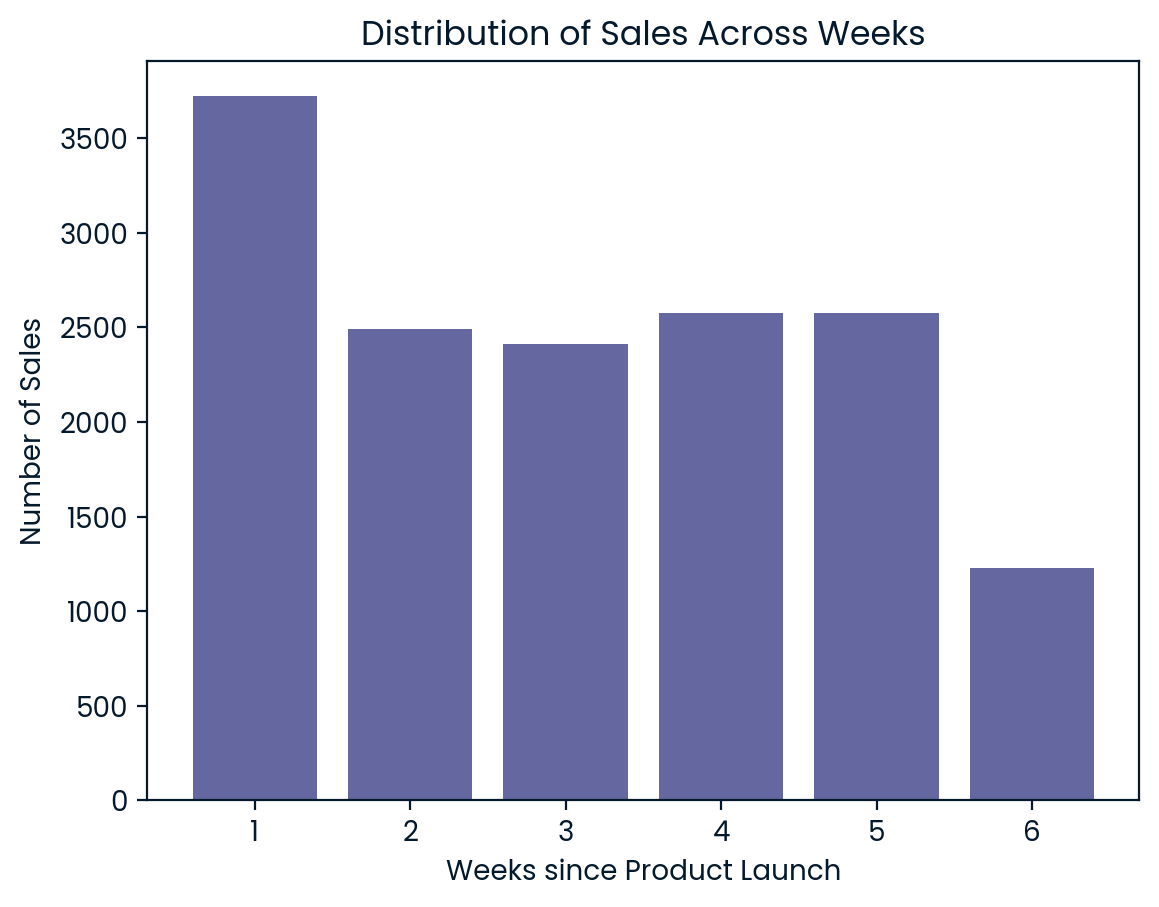

'dtype is ensured to be int64\nand unique values checks out to be true since the sales project started six weeks ago max value to expect is 6, there are no null values or negative values whatsoever'

In [3]:
sales = pd.read_csv('product_sales.csv')

print(sales['week'].dtype)
print(sales['week'].unique())
print(sales['week'].isnull().sum())

# Check the distribution of the weeks to see any abnormalities are present
week_distribution = sales['week'].value_counts().sort_index()
print(week_distribution)



plt.bar(week_distribution.index, week_distribution.values)
plt.xlabel('Weeks since Product Launch')
plt.ylabel('Number of Sales')
plt.title('Distribution of Sales Across Weeks')
plt.show()

"""dtype is ensured to be int64
and unique values checks out to be true since the sales project started six weeks ago max value to expect is 6, there are no null values or negative values whatsoever"""

In [4]:
import pandas as pd

def column_profile(df, column_name):
    col = df[column_name]
    
    # Basic Info
    data_type = col.dtype
    unique_count = col.nunique()
    null_count = col.isnull().sum()
    duplicates = col.duplicated().sum()
    
    # Numeric Info 
    min_val = max_val = mean_val = median_val = std_val = most_common = common_count = None
    if pd.api.types.is_numeric_dtype(col):
        min_val = col.min()
        max_val = col.max()
        mean_val = col.mean()
        median_val = col.median()
        std_val = col.std()
        most_common = col.mode()[0] if not col.mode().empty else None
        common_count = (col == most_common).sum() if most_common is not None else None
    
    # String Info 
    max_length = min_length = None
    if pd.api.types.is_string_dtype(col):
        max_length = col.str.len().max()
        min_length = col.str.len().min()
        most_common = col.mode()[0] if not col.mode().empty else None
        common_count = col.value_counts().max()

    # Create markdown table row
    row = f"| **{column_name}** | {data_type} | {unique_count} | {null_count} | {duplicates} | "
    row += f"{min_val if min_val is not None else 'N/A'} | {max_val if max_val is not None else 'N/A'} | "
    row += f"{mean_val if mean_val is not None else 'N/A'} | {median_val if median_val is not None else 'N/A'} | "
    row += f"{std_val if std_val is not None else 'N/A'} | {most_common if most_common is not None else 'N/A'} | "
    row += f"{common_count if common_count is not None else 'N/A'} | {max_length if max_length is not None else 'N/A'} | {min_length if min_length is not None else 'N/A'} |"
    
    return row

# Apply to all columns of a DataFrame and print as markdown table
def profile_all_columns(df):
    # Table header
    header = "| Column Name         | Data Type    | Unique Values | Null Values | Duplicated Values | Min Value | Max Value | Mean   | Median | Standard Deviation | Most Common Value | Most Common Value Count | Max String Length | Min String Length |\n"
    separator = "|---------------------|--------------|---------------|-------------|-------------------|-----------|-----------|--------|--------|--------------------|-------------------|------------------------|-------------------|-------------------|"
    
    print(header + separator)
    
    # Table rows for each column
    for col in df.columns:
        print(column_profile(df, col))

# Example usage with 'sales' DataFrame
profile_all_columns(sales)


"""initial findings are: problem with the sales method/lots of nulls with the revenue/max year is wrong company started at 1984/states seems ok/customer_id uniqueness checks out"""

| Column Name         | Data Type    | Unique Values | Null Values | Duplicated Values | Min Value | Max Value | Mean   | Median | Standard Deviation | Most Common Value | Most Common Value Count | Max String Length | Min String Length |
|---------------------|--------------|---------------|-------------|-------------------|-----------|-----------|--------|--------|--------------------|-------------------|------------------------|-------------------|-------------------|
| **week** | int64 | 6 | 0 | 14994 | 1 | 6 | 3.0982666666666665 | 3.0 | 1.656419807092205 | 1 | 3721 | N/A | N/A |
| **sales_method** | object | 5 | 0 | 14995 | N/A | N/A | N/A | N/A | N/A | Email | 7456 | 12 | 4 |
| **customer_id** | object | 15000 | 0 | 0 | N/A | N/A | N/A | N/A | N/A | 00019f95-cd18-4a2a-aa62-512cc6b17ac5 | 1 | 36 | 36 |
| **nb_sold** | int64 | 10 | 0 | 14990 | 7 | 16 | 10.084666666666667 | 10.0 | 1.8122133327416081 | 10 | 3677 | N/A | N/A |
| **revenue** | float64 | 6743 | 1074 | 8256 | 32.54 | 238.

'initial findings are: problem with the sales method/lots of nulls with the revenue/max year is wrong company started at 1984/states seems ok/customer_id uniqueness checks out'

In [5]:
sales['sales_method'].unique()

array(['Email', 'Email + Call', 'Call', 'em + call', 'email'],
      dtype=object)

In [6]:
"""fixed the typo issue"""

method_map = {
    'Email': 'Email',
    'email': 'Email',          
    'Email + Call': 'Email + Call',
    'em + call': 'Email + Call', 
    'Call': 'Call'
}

sales['sales_method'] = sales['sales_method'].map(method_map)

print(sales['sales_method'].value_counts())

sales_method
Email           7466
Call            4962
Email + Call    2572
Name: count, dtype: int64


In [7]:
sales['state'].value_counts()

state
California        1872
Texas             1187
New York           965
Florida            904
Illinois           617
Pennsylvania       598
Ohio               566
Michigan           498
Georgia            489
North Carolina     459
New Jersey         434
Virginia           372
Indiana            354
Tennessee          340
Washington         335
Arizona            321
Missouri           311
Massachusetts      294
Maryland           263
Wisconsin          253
Minnesota          245
Colorado           230
Louisiana          230
Oregon             229
South Carolina     224
Alabama            214
Kentucky           213
Oklahoma           196
Connecticut        179
Iowa               165
Kansas             142
Mississippi        139
Arkansas           132
Utah               124
Nevada             102
Nebraska            91
West Virginia       85
New Mexico          84
Hawaii              72
Maine               63
Idaho               62
New Hampshire       53
Montana             45
Rhode

In [8]:
# List of all valid US state names
valid_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 
    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 
    'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 
    'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 
    'Wisconsin', 'Wyoming'
]

# Check for invalid state names
invalid_states = sales[~sales['state'].isin(valid_states)]
print("Invalid states found:")
print(invalid_states)


"""states are validated"""

Invalid states found:
Empty DataFrame
Columns: [week, sales_method, customer_id, nb_sold, revenue, years_as_customer, nb_site_visits, state]
Index: []


'states are validated'

In [9]:
# Check rows where revenue is null
null_revenue_rows = sales[sales['revenue'].isnull()]
null_revenue_rows

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
16,2,Email,0f744f79-1588-4e0c-8865-fdaecc7f6dd4,10,NaN,6,30,Pennsylvania
17,6,Email + Call,d10690f0-6f63-409f-a1da-8ab0e5388390,15,NaN,0,24,Wisconsin
28,5,Email,f64f8fd5-e9b7-4326-9f5d-ef283f14d7ad,12,NaN,4,32,Florida
...,...,...,...,...,...,...,...,...
14951,5,Call,5f1c099a-3cf2-4c32-91f0-5ec802926073,10,NaN,10,25,Virginia
14957,1,Call,b7947946-8b0a-4031-8835-226200f260a5,7,NaN,5,23,Illinois
14970,4,Email + Call,72be03aa-25b1-4574-b358-74118cd8d81a,12,NaN,12,25,Washington
14992,5,Email + Call,cd9e6945-ae21-4bed-a6cf-f0302e6c4795,12,NaN,1,34,New York


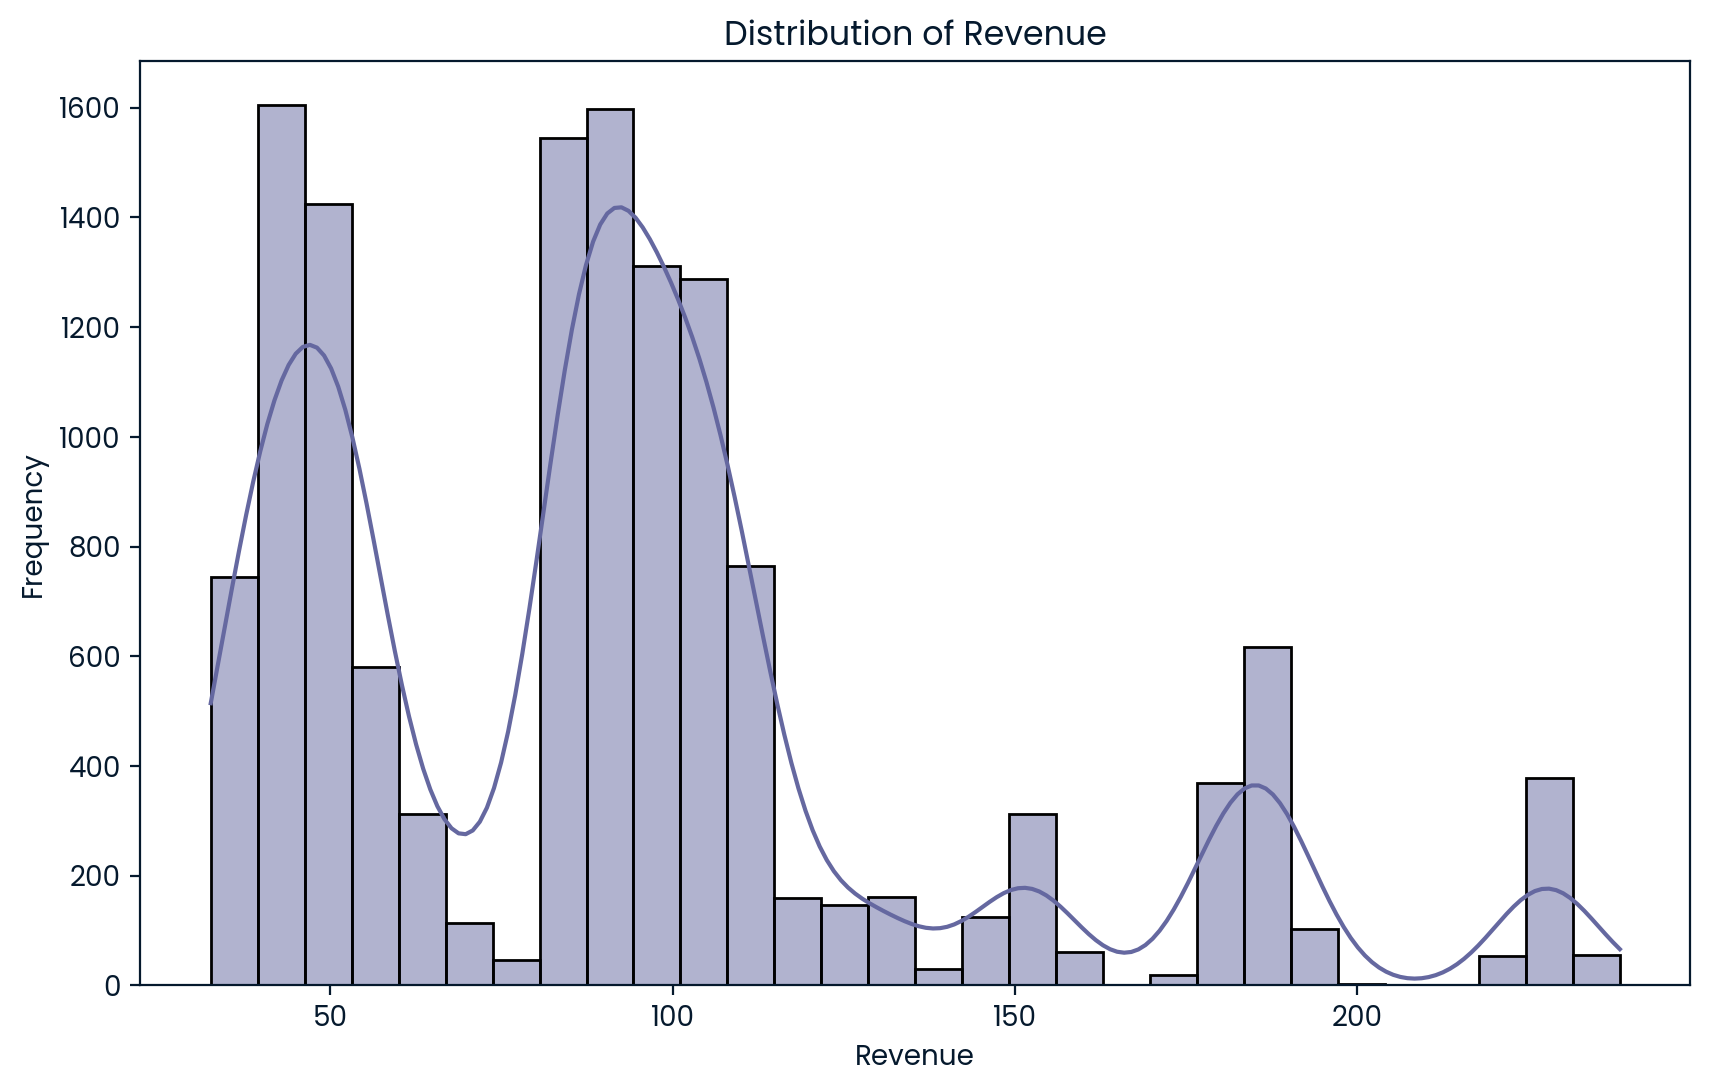

Skewness of the revenue column: 1.0824031729892225


In [10]:

# Plot a histogram of revenue
plt.figure(figsize=(10, 6))
sns.histplot(sales['revenue'].dropna(), kde=True, bins=30)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

# Calculate skewness to check for asymmetry
print(f"Skewness of the revenue column: {sales['revenue'].skew()}")


In [11]:
"""revenue problem is solved via median replacement for each sales method approach as the distribution looking rather skewed"""

# Calculate the median revenue for each sales method
method_medians = sales.groupby('sales_method')['revenue'].median()

# Fill missing revenue values with the median of the corresponding sales method
sales['revenue'] = sales.apply(
    lambda row: method_medians[row['sales_method']] if pd.isnull(row['revenue']) else row['revenue'], axis=1
)

# Check to ensure no more missing values in the revenue column
print(sales['revenue'].isnull().sum())


0


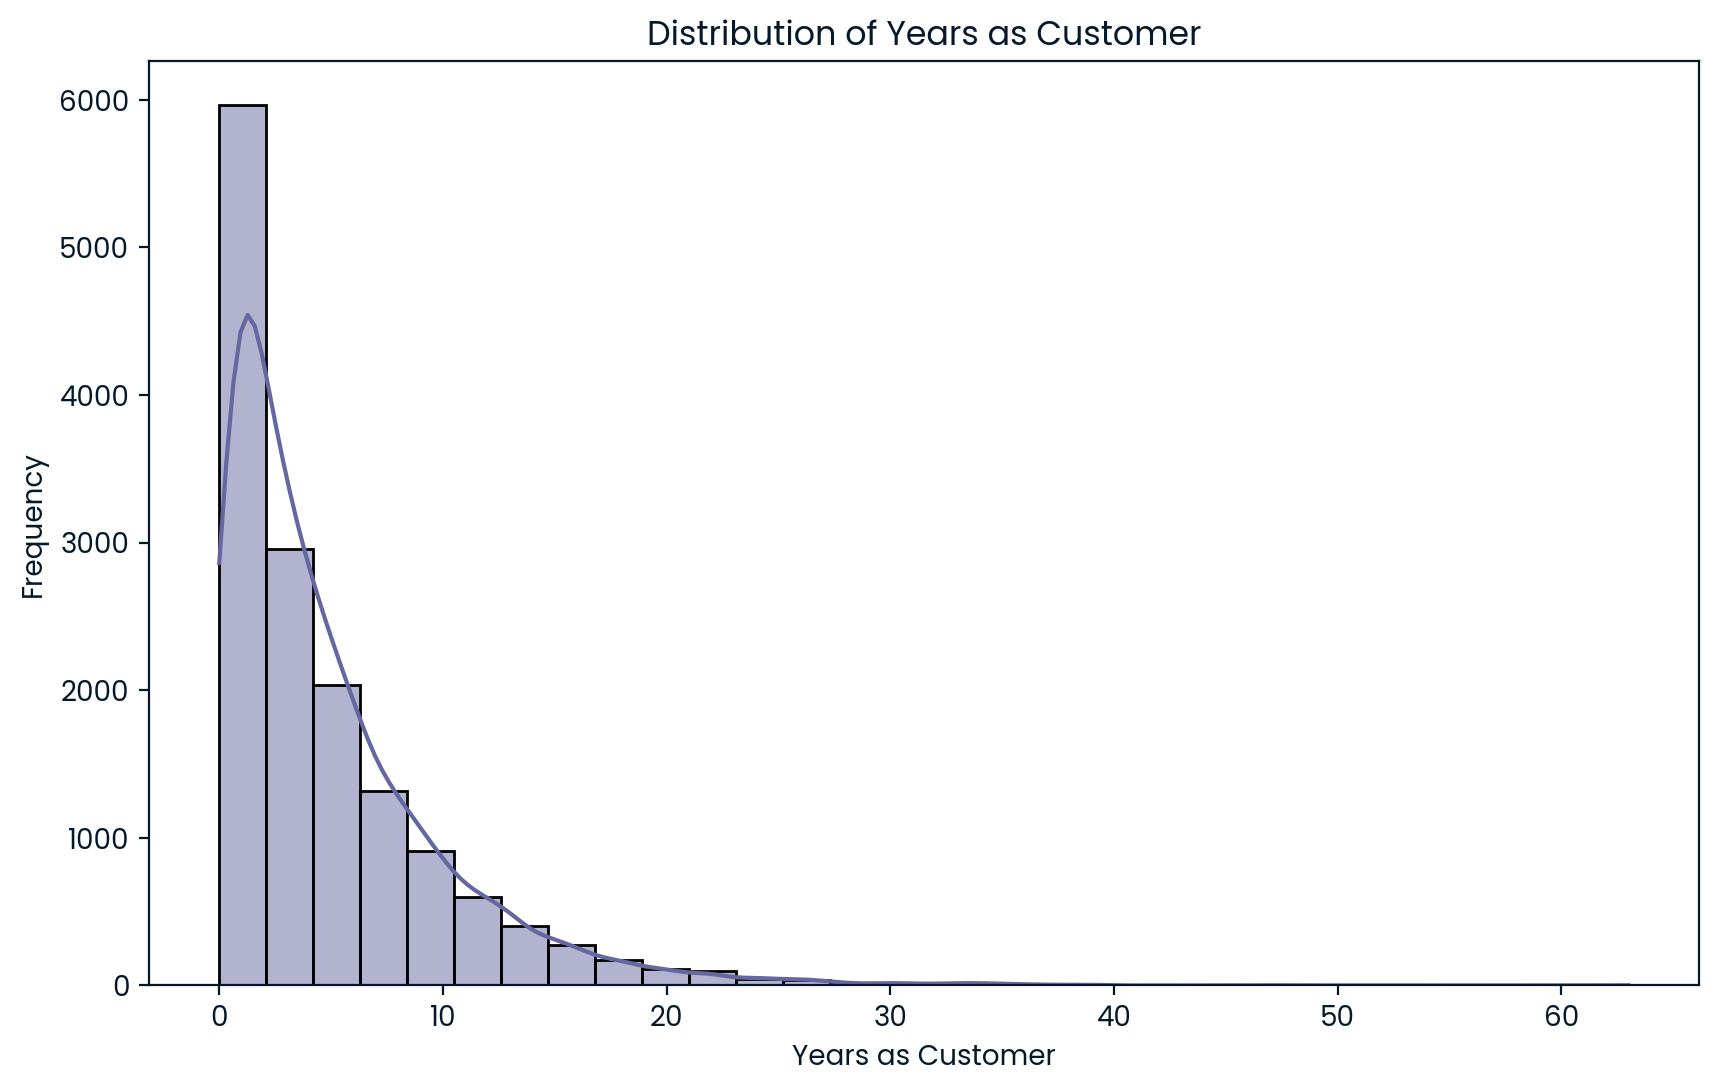

count    15000.000000
mean         4.965933
std          5.044952
min          0.000000
25%          1.000000
50%          3.000000
75%          7.000000
max         63.000000
Name: years_as_customer, dtype: float64


In [12]:

# Plot the distribution of 'years_as_customer'
plt.figure(figsize=(10, 6))
sns.histplot(sales['years_as_customer'], kde=True, bins=30)
plt.title('Distribution of Years as Customer')
plt.xlabel('Years as Customer')
plt.ylabel('Frequency')
plt.show()

# Describe the 'years_as_customer' column
print(sales['years_as_customer'].describe())


In [13]:
# Check if the 'years_as_customer' column contains the number 39
contains_39 = 39 in sales['years_as_customer'].values
contains_39

True

In [14]:
# Define the latest possible year for the dataset (e.g., 2023)
latest_year = 2023
company_start_year = 1984

# Calculate the maximum valid 'years_as_customer' value
max_valid_years = latest_year - company_start_year

# Alternatively, if you want to cap the values:
sales['years_as_customer'] = sales['years_as_customer'].apply(lambda x: min(x, max_valid_years))

print(sales['years_as_customer'].describe())

count    15000.000000
mean         4.963800
std          5.026295
min          0.000000
25%          1.000000
50%          3.000000
75%          7.000000
max         39.000000
Name: years_as_customer, dtype: float64


In [15]:
sales.describe(include='all')

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
count,15000.000000,15000,15000,15000.000000,15000.000000,15000.000000,15000.000000,15000
unique,NaN,3,15000,NaN,NaN,NaN,NaN,50
top,NaN,Email,2e72d641-95ac-497b-bbf8-4861764a7097,NaN,NaN,NaN,NaN,California
freq,NaN,7466,1,NaN,NaN,NaN,NaN,1872
mean,3.098267,NaN,NaN,10.084667,95.565964,4.963800,24.990867,NaN
std,1.656420,NaN,NaN,1.812213,47.985182,5.026295,3.500914,NaN
min,1.000000,NaN,NaN,7.000000,32.540000,0.000000,12.000000,NaN
25%,2.000000,NaN,NaN,9.000000,52.650000,1.000000,23.000000,NaN
50%,3.000000,NaN,NaN,10.000000,90.950000,3.000000,25.000000,NaN
75%,5.000000,NaN,NaN,11.000000,107.750000,7.000000,27.000000,NaN


also do a visualisation that presents total revenue gained by each method aswell, point here is to compare the weighted comparison between email and email and call, email seems best but it is also the most done method, check that whether if email and call had reached the same amounts of trying with its current performance how would that be look like.

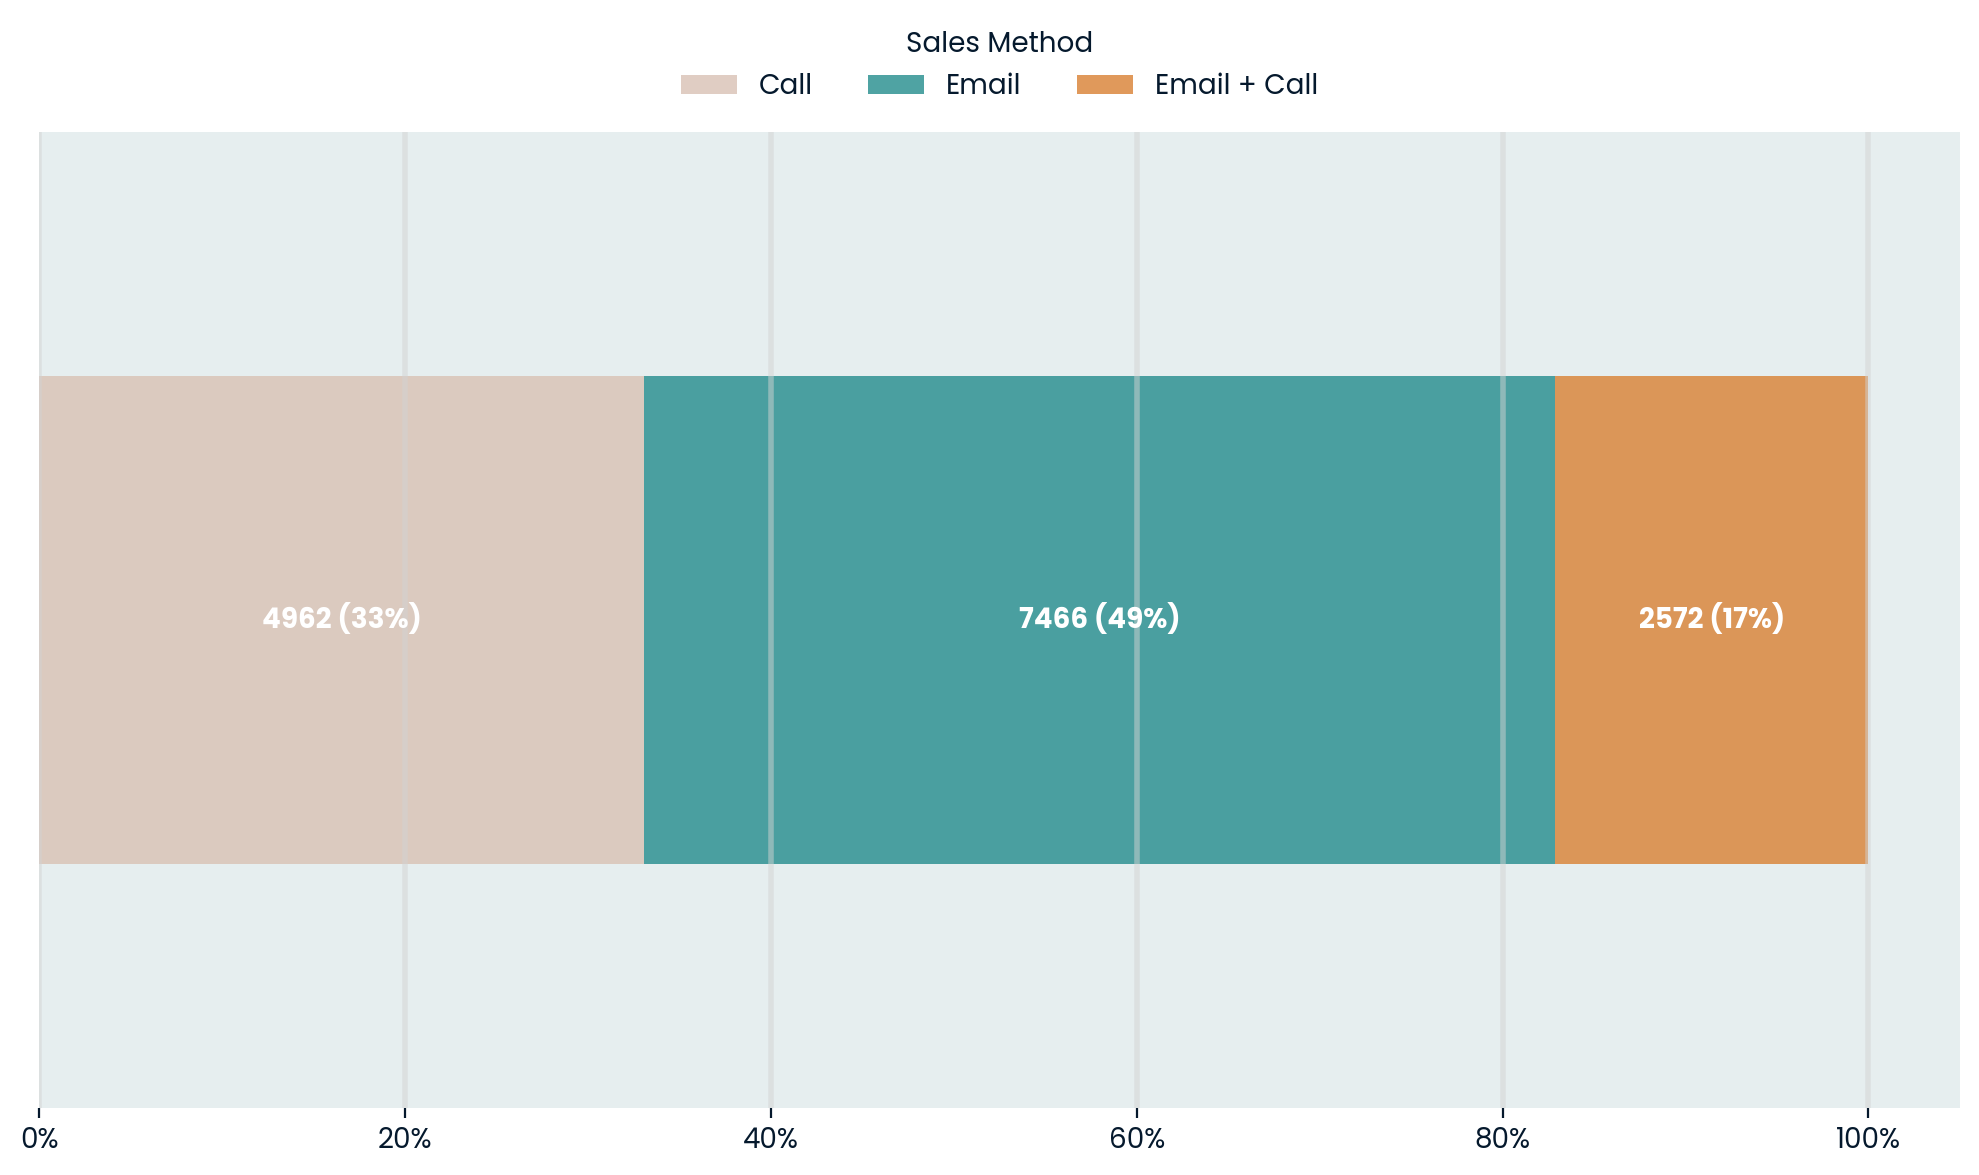

In [16]:
sales_method_counts = sales.groupby('sales_method')['customer_id'].count()  # Count of customers per sales method

# Calculate the percentage for each sales method
sales_method_percentages = sales_method_counts / sales_method_counts.sum()

# Convert to DataFrame for easier manipulation
df_grouped = pd.DataFrame(sales_method_percentages).T

# Set up figure and axis with transparency control
fig, ax = plt.subplots(figsize=(10, 6))

# Create the 100% stacked horizontal bar chart with transparency
colors = ['#D9C1B4','#238C8C', '#D98032']
bars = df_grouped.plot.barh(stacked=True, ax=ax, color=colors, alpha=0.8)

# Remove the rectangle outline
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove y-axis value names 
ax.set_yticks([])

# Remove plot title
ax.set_title("")

# Customize the legend
plt.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
    title='Sales Method'
)

# Add the data labels for both exact numbers and percentages
for ix, row in df_grouped.reset_index(drop=True).iterrows():
    cumulative = 0
    for i, element in enumerate(row.values):
        if element > 0.01:  # Only label bars with a significant percentage
            # Exact count of customers
            exact_count = sales_method_counts[i]
            
            # Add both exact count and percentage
            plt.text(
                cumulative + element / 2,  # Position the text in the middle of the bar segment
                ix,  # Y position of the bar
                f"{exact_count} ({int(element * 100)}%)",  # Display exact number and percentage value
                va="center",  # Vertically align text in the center of the bar
                ha="center",  # Horizontally align text in the center of the bar
                color="white",  # Text color (white for visibility)
                fontweight="bold"  # Bold font for better visibility
            )
        cumulative += element  # Increment cumulative value for the next segment

# Customizations gridlines and background transparency
plt.grid(axis='x', linestyle='-', linewidth=2, color='lightgray',alpha = 0.5) 
ax.set_facecolor('#DCE7E9')
ax.patch.set_alpha(0.7) 

# X-axis should display percentage ticks
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


plt.tight_layout()
plt.show()


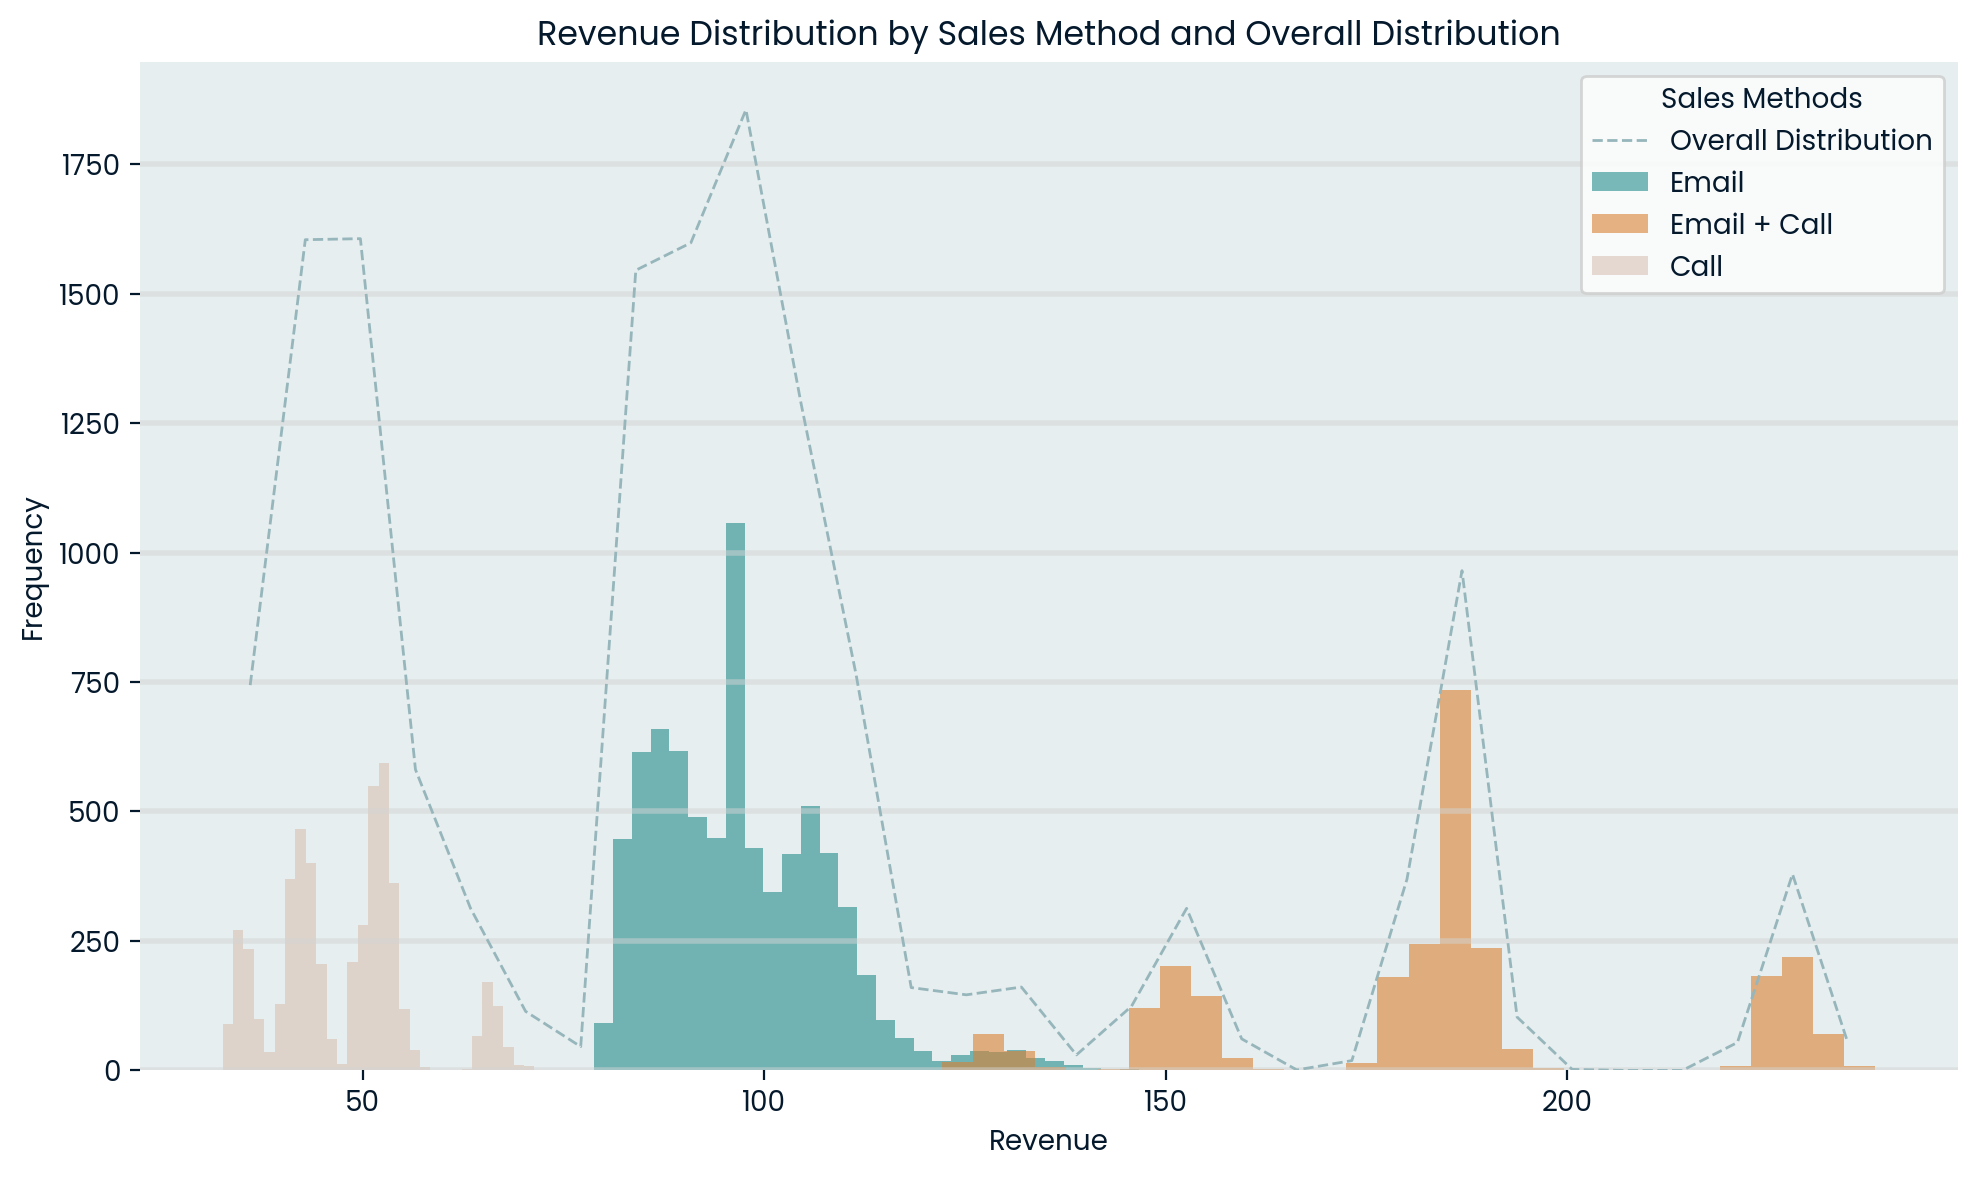

In [17]:
methods = sales['sales_method'].unique()

# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each sales method histogram
colors = ['#238C8C', '#D98032', '#D9C1B4']

# Plot histograms for each sales method without bar borders and with transparency
for i, method in enumerate(methods):
    subset = sales[sales['sales_method'] == method]
    sns.histplot(subset['revenue'], label=method, bins=30, color=colors[i], kde=False, alpha=0.6, edgecolor=None, ax=ax)

# Calculate overall revenue histogram for line plot
revenue_counts, bin_edges = np.histogram(sales['revenue'], bins=30)

# Plot the overall distribution as a line plot on the same x-axis (scaled to frequency)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.plot(bin_centers, revenue_counts, label='Overall Distribution', color='#96B6BC', linestyle='--', linewidth=1)


# Customizing aesthetics
# Remove plot outline
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add gridlines, background color, and transparency
plt.grid(axis='y', linestyle='-', linewidth=2, color='lightgray', alpha=0.5)  
ax.set_facecolor('#DCE7E9')  
ax.patch.set_alpha(0.7)  

# Set title and axis labels
plt.title('Revenue Distribution by Sales Method and Overall Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')


plt.legend(title='Sales Methods')


plt.tight_layout()
plt.show()


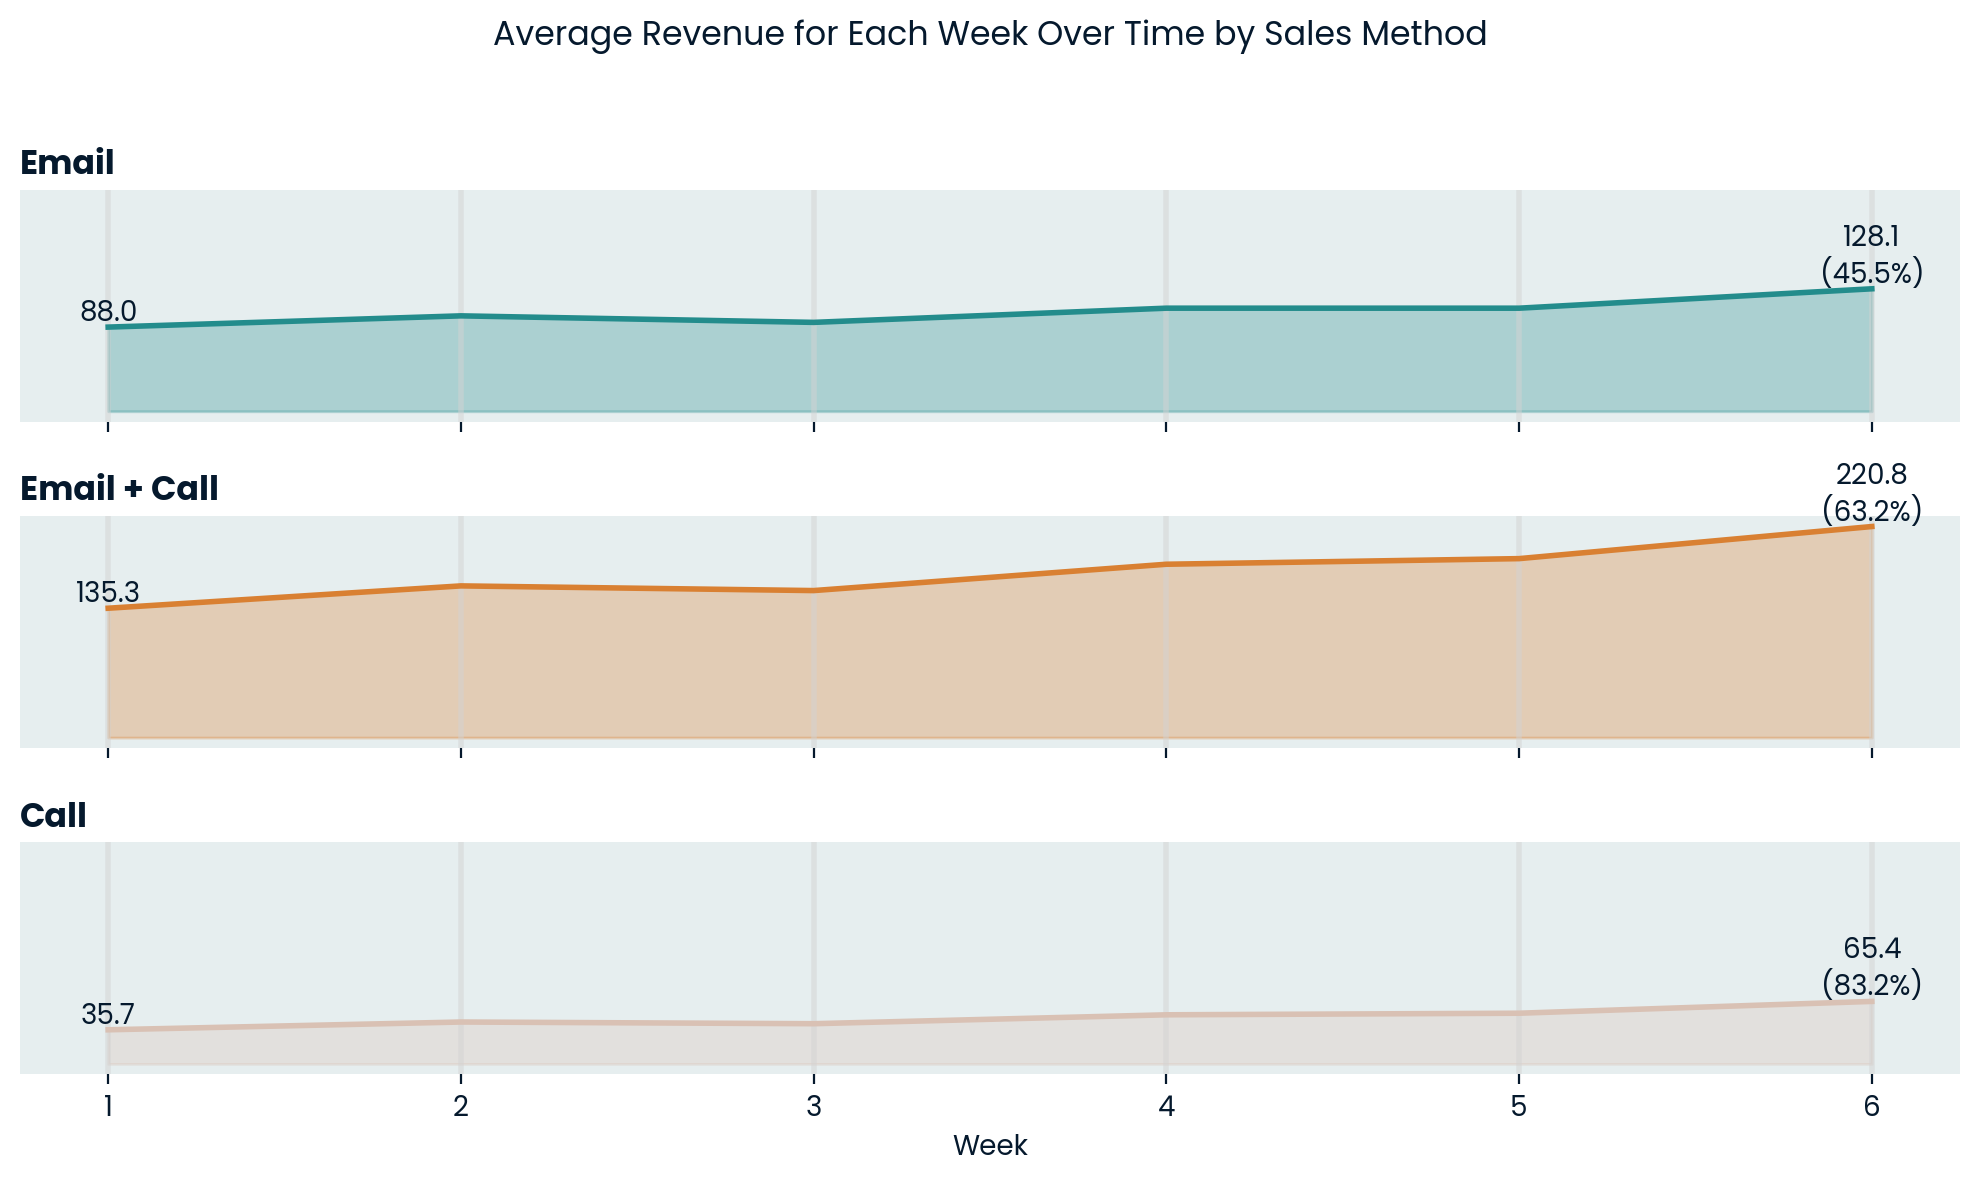

In [18]:
methods = sales['sales_method'].unique()
weeks = sales['week'].unique()

# Set up the figure with subplots for each sales method
fig, axes = plt.subplots(nrows=len(methods), figsize=(10, 6), sharex=True, sharey=True)

# Colors and customization
colors = ['#238C8C', '#D98032', '#D9C1B4'] 

# Iterate over each sales method and create a separate plot
for i, method in enumerate(methods):
    ax = axes[i]
    subset = sales[sales['sales_method'] == method].groupby('week')['revenue'].mean().reset_index()

    # Calculate percentage growth for each method
    initial_value = subset['revenue'].iloc[0]
    final_value = subset['revenue'].iloc[-1]
    absolute_change = final_value - initial_value
    percent_change = (absolute_change / initial_value) * 100

    # Plot line chart with shaded area
    ax.fill_between(subset['week'], subset['revenue'], color=colors[i], alpha=0.3)  # Area plot
    ax.plot(subset['week'], subset['revenue'], color=colors[i], linewidth=2)  # Line plot

    # Add data labels for the start and end values
    ax.text(subset['week'].iloc[0], initial_value, f"{initial_value:.1f}", ha='center', va='bottom')
    ax.text(subset['week'].iloc[-1], final_value, f"{final_value:.1f}\n({percent_change:.1f}%)", ha='center', va='bottom')

    # Remove y-axis labels for a sparkline-like look
    ax.set_yticks([])

    # Title for each subplot
    ax.set_title(method, loc='left', fontweight='bold')

# Customize the overall appearance
plt.suptitle('Average Revenue for Each Week Over Time by Sales Method')
plt.xlabel('Week')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for title

# Customize the theme
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.grid(axis='x', linestyle='-', linewidth=2, color='lightgray', alpha=0.5)  # Vertical gridlines
    ax.set_facecolor('#DCE7E9')  # Background color 
    ax.patch.set_alpha(0.7)

plt.show()


In [21]:
# Adding a time_spent column
sales['time_spent'] = sales['sales_method'].map({
    'Email': 5,  # assuming 5 minutes per email
    'Call': 30,  # assuming 30 minutes per call
    'Email + Call': 15  # assuming 5 minutes for email and 10 minutes for call
})

# Group by sales method and calculate metrics, including nb_sold_sum
grouped_data = sales.groupby('sales_method').agg({
    'revenue': ['mean', 'sum'], 
    'nb_sold': ['mean', 'sum'],  # Added sum of nb_sold here
    'nb_site_visits': 'mean', 
    'years_as_customer': 'mean',
    'week': 'mean',  
    'time_spent': 'sum'  
})

# Flatten the multi-level columns for easier access
grouped_data.columns = ['_'.join(col).strip() for col in grouped_data.columns.values]

# Create additional columns like revenue per item and revenue per time
grouped_data['revenue_per_item'] = grouped_data['revenue_sum'] / grouped_data['nb_sold_sum']  # Now uses total sold items
grouped_data['revenue_per_time'] = grouped_data['revenue_sum'] / grouped_data['time_spent_sum']

# Define weights for each metric
weights = {
    'revenue_per_item': 0.3,
    'revenue_per_time': 0.4,
    'nb_site_visits_mean': 0.1,
    'years_as_customer_mean': 0.2,
}

# Apply weights to create composite score
grouped_data['composite_score'] = (grouped_data['revenue_per_item'] * weights['revenue_per_item'] +
                                   grouped_data['revenue_per_time'] * weights['revenue_per_time'] +
                                   grouped_data['nb_site_visits_mean'] * weights['nb_site_visits_mean'] +
                                   grouped_data['years_as_customer_mean'] * weights['years_as_customer_mean'])

# Sort by composite score
grouped_data = grouped_data.sort_values(by='composite_score', ascending=False)

grouped_data

,revenue_mean,revenue_sum,nb_sold_mean,nb_sold_sum,nb_site_visits_mean,years_as_customer_mean,week_mean,time_spent_sum,revenue_per_item,revenue_per_time,composite_score
sales_method,,,,,,,,,,,
Email,97.014914,724313.35,9.729306,72639,24.754353,4.980579,2.469060,37330,9.971411,19.402983,14.224168
Email + Call,183.798970,472730.95,12.225505,31444,26.771384,4.507387,4.291602,38580,15.034059,12.253265,12.990139
Call,47.651181,236445.16,9.509674,47187,24.423821,5.175131,3.426441,148860,5.010811,1.588373,5.616001


In [22]:
grouped_data

,revenue_mean,revenue_sum,nb_sold_mean,nb_sold_sum,nb_site_visits_mean,years_as_customer_mean,week_mean,time_spent_sum,revenue_per_item,revenue_per_time,composite_score
sales_method,,,,,,,,,,,
Email,97.014914,724313.35,9.729306,72639,24.754353,4.980579,2.469060,37330,9.971411,19.402983,14.224168
Email + Call,183.798970,472730.95,12.225505,31444,26.771384,4.507387,4.291602,38580,15.034059,12.253265,12.990139
Call,47.651181,236445.16,9.509674,47187,24.423821,5.175131,3.426441,148860,5.010811,1.588373,5.616001


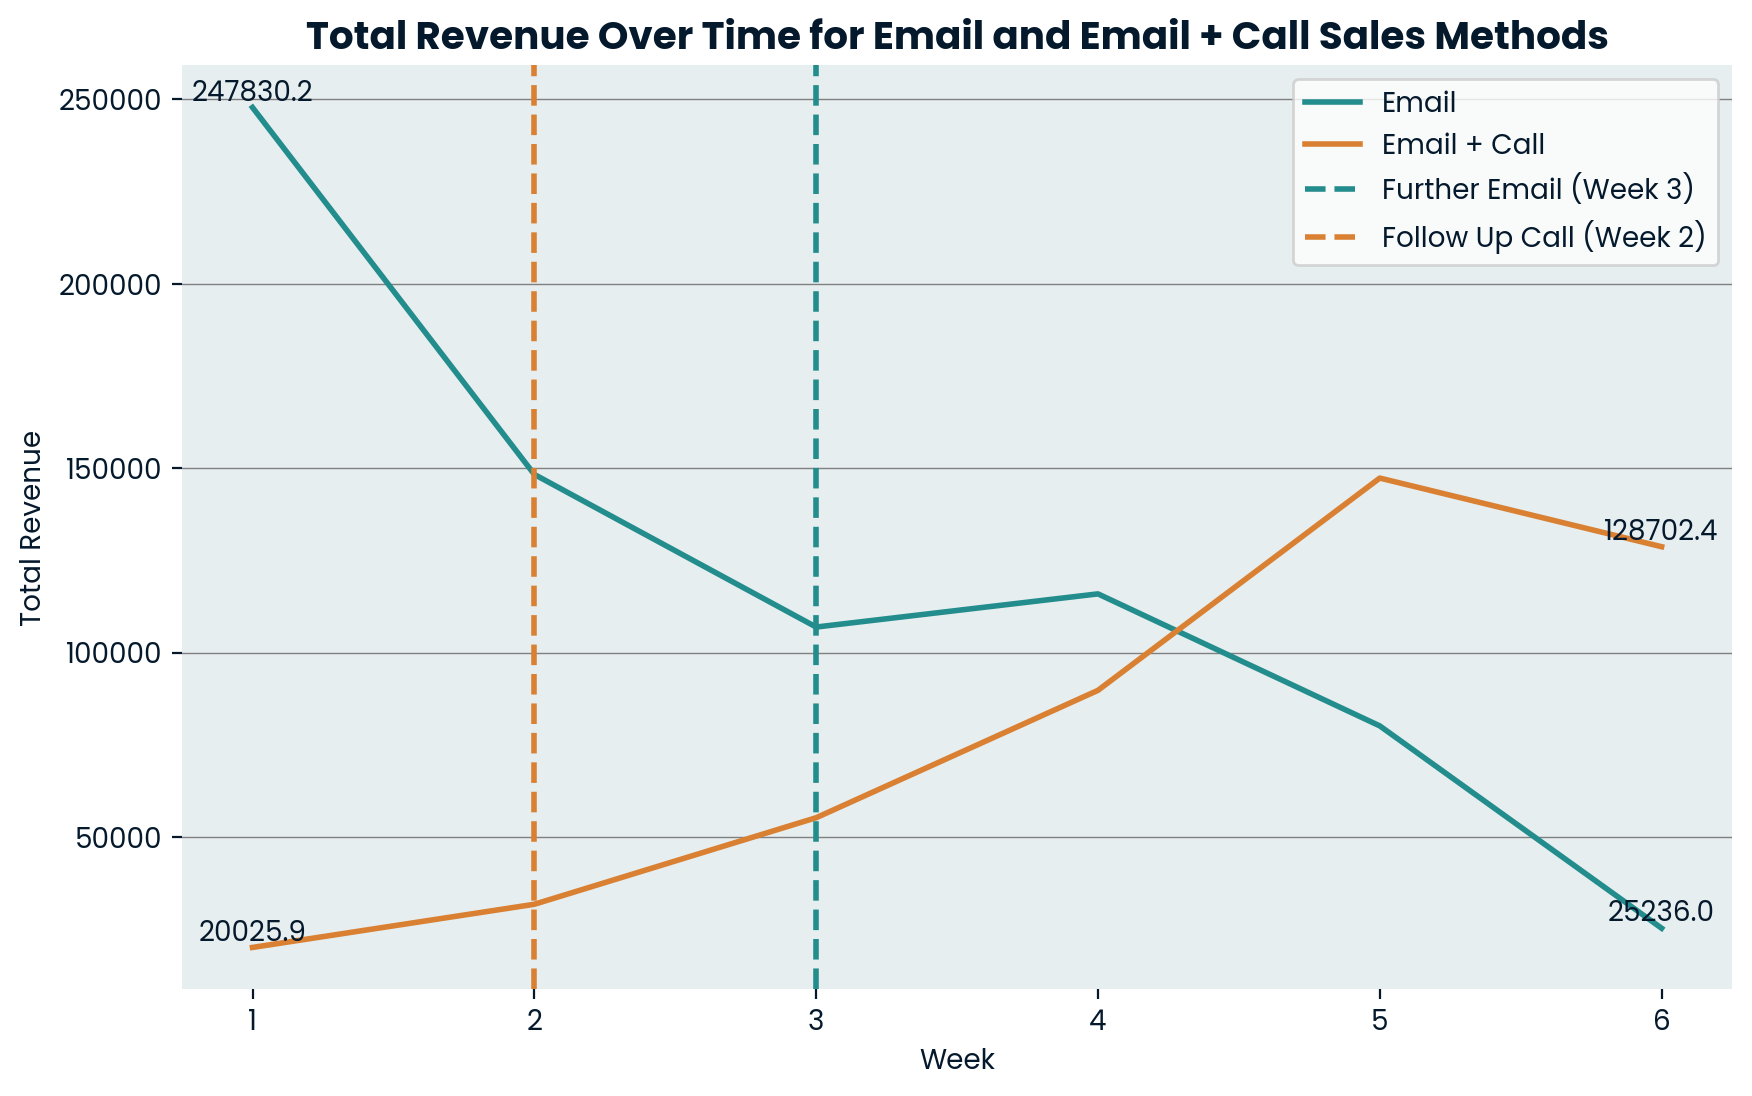

In [23]:
email_subset = sales[sales['sales_method'] == 'Email'].groupby('week')['revenue'].sum().reset_index()
email_call_subset = sales[sales['sales_method'] == 'Email + Call'].groupby('week')['revenue'].sum().reset_index()
# Set up the figure for the line plot
plt.figure(figsize=(10, 6))

# Plot the total revenue for each week (Email)
if not email_subset.empty:
    plt.plot(email_subset['week'], email_subset['revenue'], color='#238C8C', linewidth=2, label='Email')

    # Add data labels for the start and end values
    initial_value_email = email_subset['revenue'].iloc[0]
    final_value_email = email_subset['revenue'].iloc[-1]
    plt.text(email_subset['week'].iloc[0], initial_value_email, f"{initial_value_email:.1f}", ha='center', va='bottom')
    plt.text(email_subset['week'].iloc[-1], final_value_email, f"{final_value_email:.1f}", ha='center', va='bottom')

# Plot the total revenue for each week (Email + Call)
if not email_call_subset.empty:
    plt.plot(email_call_subset['week'], email_call_subset['revenue'], color='#D98032', linewidth=2, label='Email + Call')

    # Add data labels for the start and end values
    initial_value_email_call = email_call_subset['revenue'].iloc[0]
    final_value_email_call = email_call_subset['revenue'].iloc[-1]
    plt.text(email_call_subset['week'].iloc[0], initial_value_email_call, f"{initial_value_email_call:.1f}", ha='center', va='bottom')
    plt.text(email_call_subset['week'].iloc[-1], final_value_email_call, f"{final_value_email_call:.1f}", ha='center', va='bottom')

# Add vertical lines for Week 3 and Week 2 with names in the legend
if 3 in sales['week'].unique():
    plt.axvline(x=3, color='#238C8C', linestyle='--', linewidth=2, label='Further Email (Week 3)')
if 2 in sales['week'].unique():
    plt.axvline(x=2, color='#D98032', linestyle='--', linewidth=2, label='Follow Up Call (Week 2)')

# Customize the appearance:
# 1. Remove plot spines (outline)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# 2. Set the background color for the plot
plt.gca().set_facecolor('#DCE7E9')  
plt.gca().patch.set_alpha(0.7)
# 3. Show only horizontal gridlines, solid and grey
plt.grid(visible=True, axis='y', color='grey', linestyle='-', linewidth=0.5)

# Customize titles and labels
plt.title('Total Revenue Over Time for Email and Email + Call Sales Methods', fontsize=14, fontweight='bold')
plt.xlabel('Week')
plt.ylabel('Total Revenue')


plt.legend()


plt.show()


<Axes: title={'center': 'Customer Types by Sales Method'}, xlabel='sales_method'>

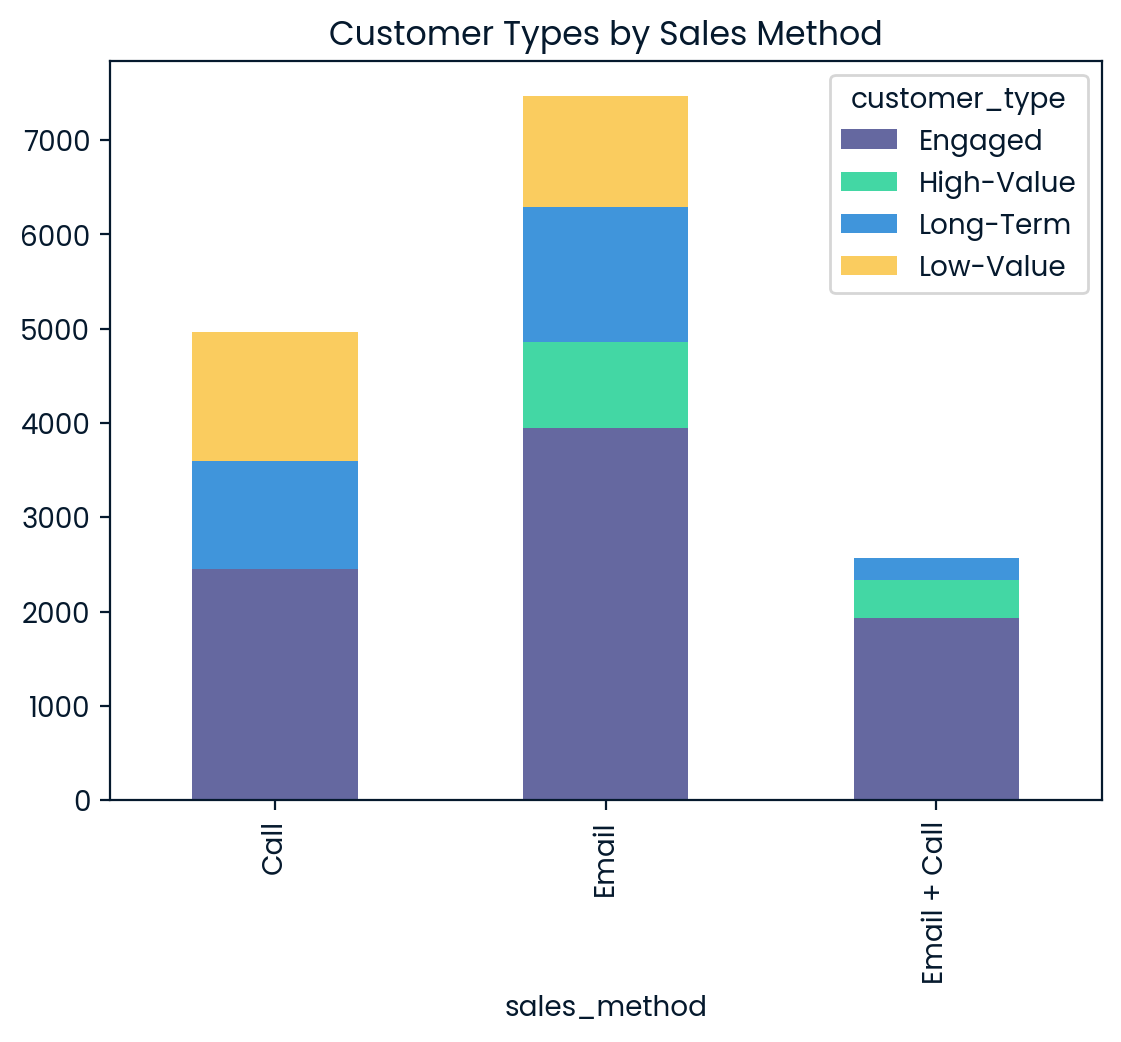

In [24]:
# Define thresholds for different customer types
revenue_threshold = sales['revenue'].mean()
years_threshold = sales['years_as_customer'].mean()
visits_threshold = sales['nb_site_visits'].mean()

# Create customer type labels
sales['customer_type'] = ['High-Value' if x >= revenue_threshold else 'Low-Value' for x in sales['revenue']]
sales['customer_type'] = sales.apply(lambda x: 'Long-Term' if x['years_as_customer'] > years_threshold else x['customer_type'], axis=1)
sales['customer_type'] = sales.apply(lambda x: 'Engaged' if x['nb_site_visits'] > visits_threshold else x['customer_type'], axis=1)

# Visualize customer types per sales method
customer_type_dist = sales.groupby(['sales_method', 'customer_type']).size().unstack()
customer_type_dist.plot(kind='bar', stacked=True, title='Customer Types by Sales Method')


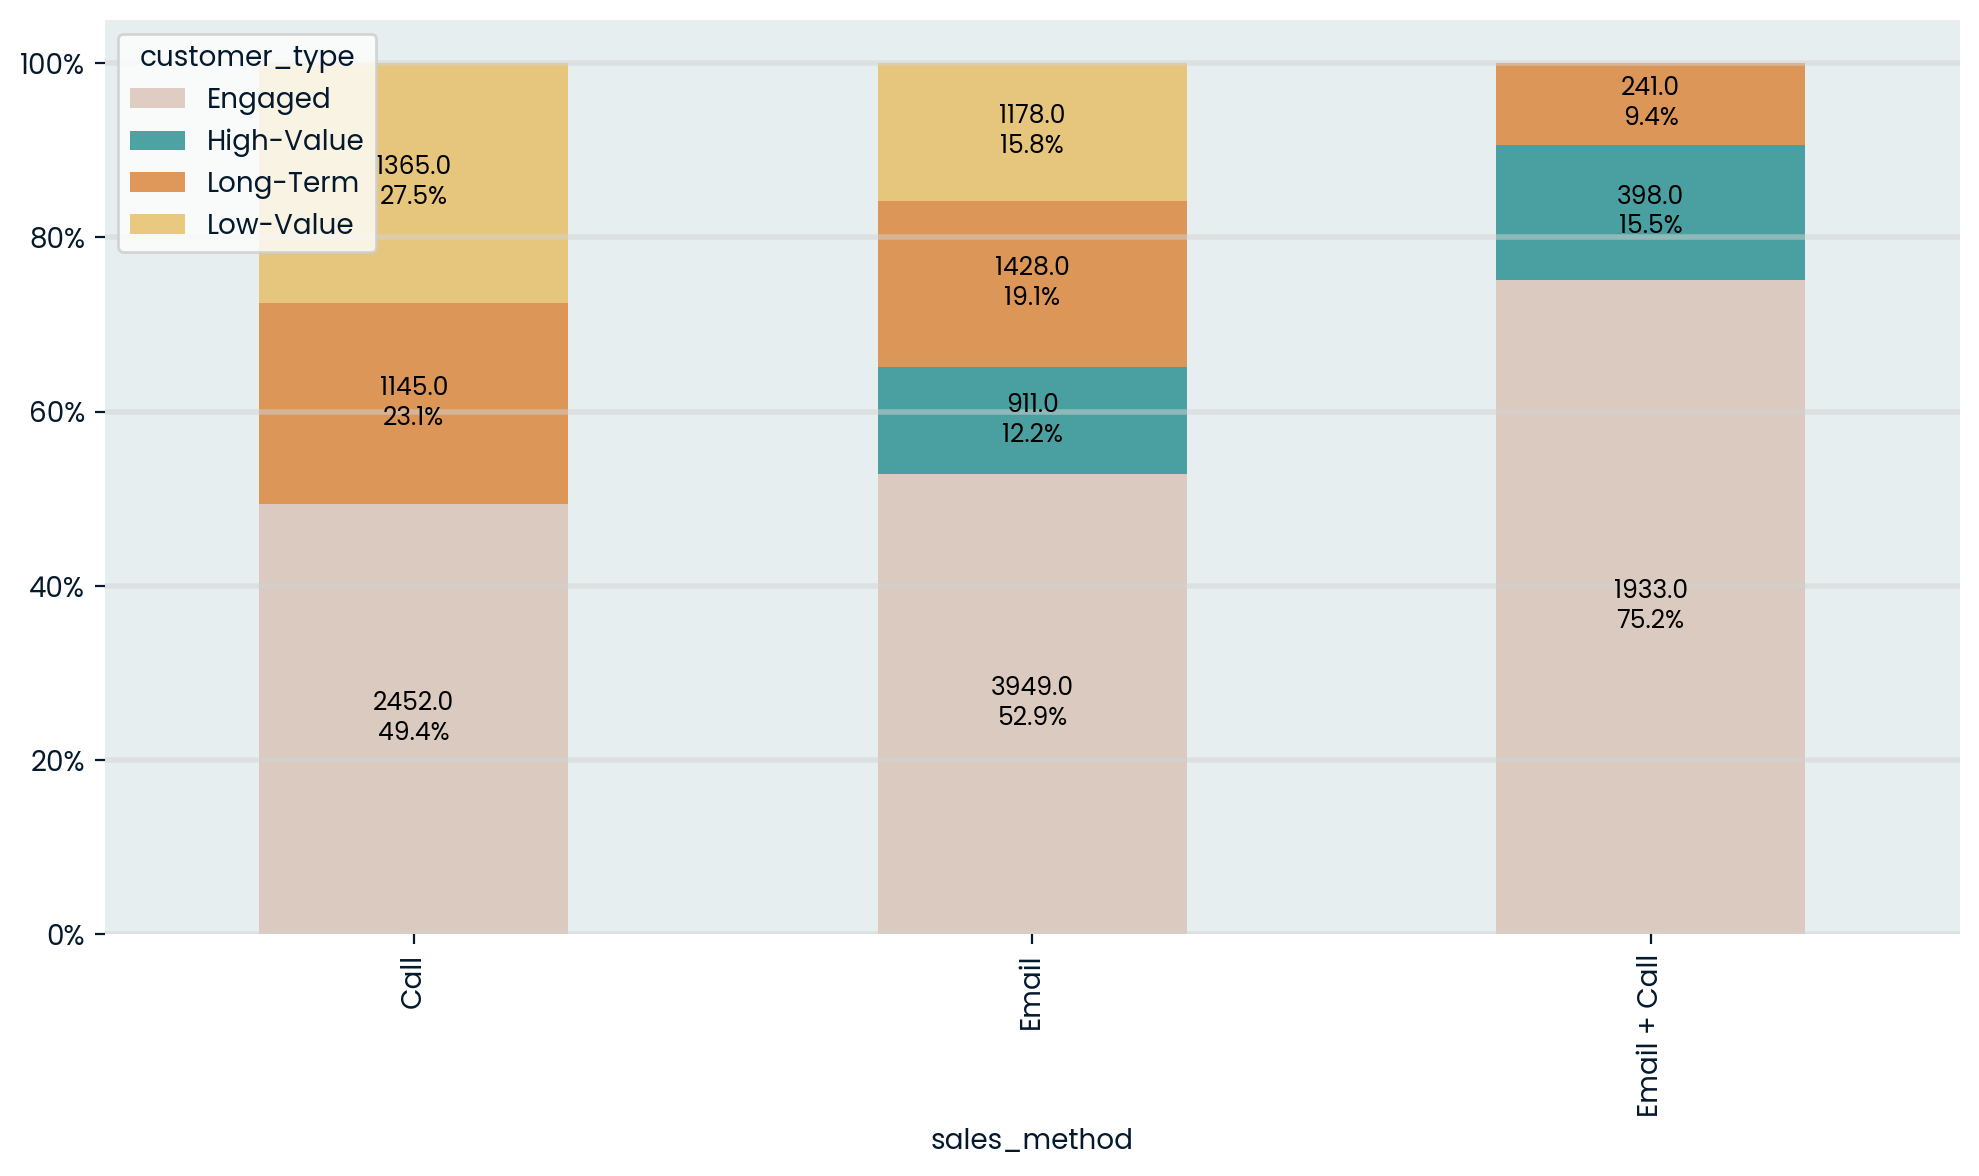

In [25]:
# Convert to percentages for 100% stacked chart
customer_type_percentages = customer_type_dist.divide(customer_type_dist.sum(axis=1), axis=0)

# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors
colors = ['#D9C1B4', '#238C8C', '#D98032','#E6BD61']

# Create the 100% stacked bar chart
bars = customer_type_percentages.plot(kind='bar', stacked=True, ax=ax, color=colors, alpha=0.8)

# Y-axis should display percentage ticks
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

# Remove the rectangle outline
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Customizations: gridlines and background transparency
plt.grid(axis='y', linestyle='-', linewidth=2, color='lightgray', alpha=0.5)  # Horizontal gridlines only
ax.set_facecolor('#DCE7E9') 
ax.patch.set_alpha(0.7)  

# Add data labels to each segment (counts and percentages)
for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        width = bar.get_width()
        if height > 0:  # Only label bars with non-zero height
            x = bar.get_x() + width / 2  # X position of the label
            y = bar.get_y() + height / 2  # Y position of the label

            # Find the corresponding category and row index
            row_idx = int(bar.get_x() + 0.5)
            category = container.get_label()

            # Get the count and percentage for this bar segment
            count = customer_type_dist.iloc[row_idx][category]
            percentage = customer_type_percentages.iloc[row_idx][category] * 100

            # Add the label with both count and percentage
            ax.text(bar.get_x() + bar.get_width() / 2, 
                    bar.get_y() + bar.get_height() / 2, 
                    f'{count}\n{percentage:.1f}%', 
                    ha='center', va='center', fontsize=9, color='black')

# Final layout
plt.tight_layout()
plt.show()



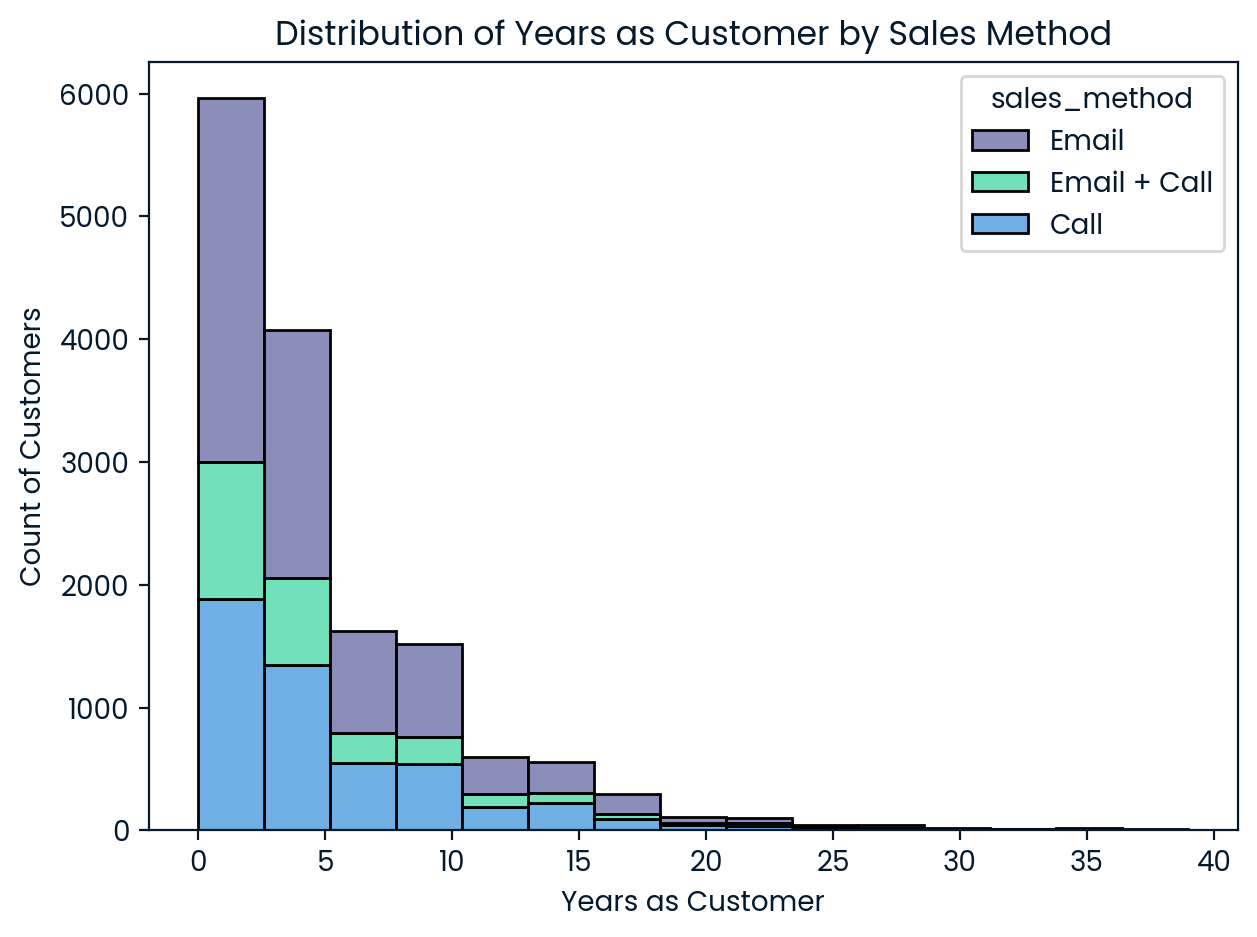

In [26]:
sns.histplot(data=sales, x='years_as_customer', hue='sales_method', multiple='stack', bins=15)

plt.title('Distribution of Years as Customer by Sales Method')
plt.xlabel('Years as Customer')
plt.ylabel('Count of Customers')

plt.tight_layout()
plt.show()

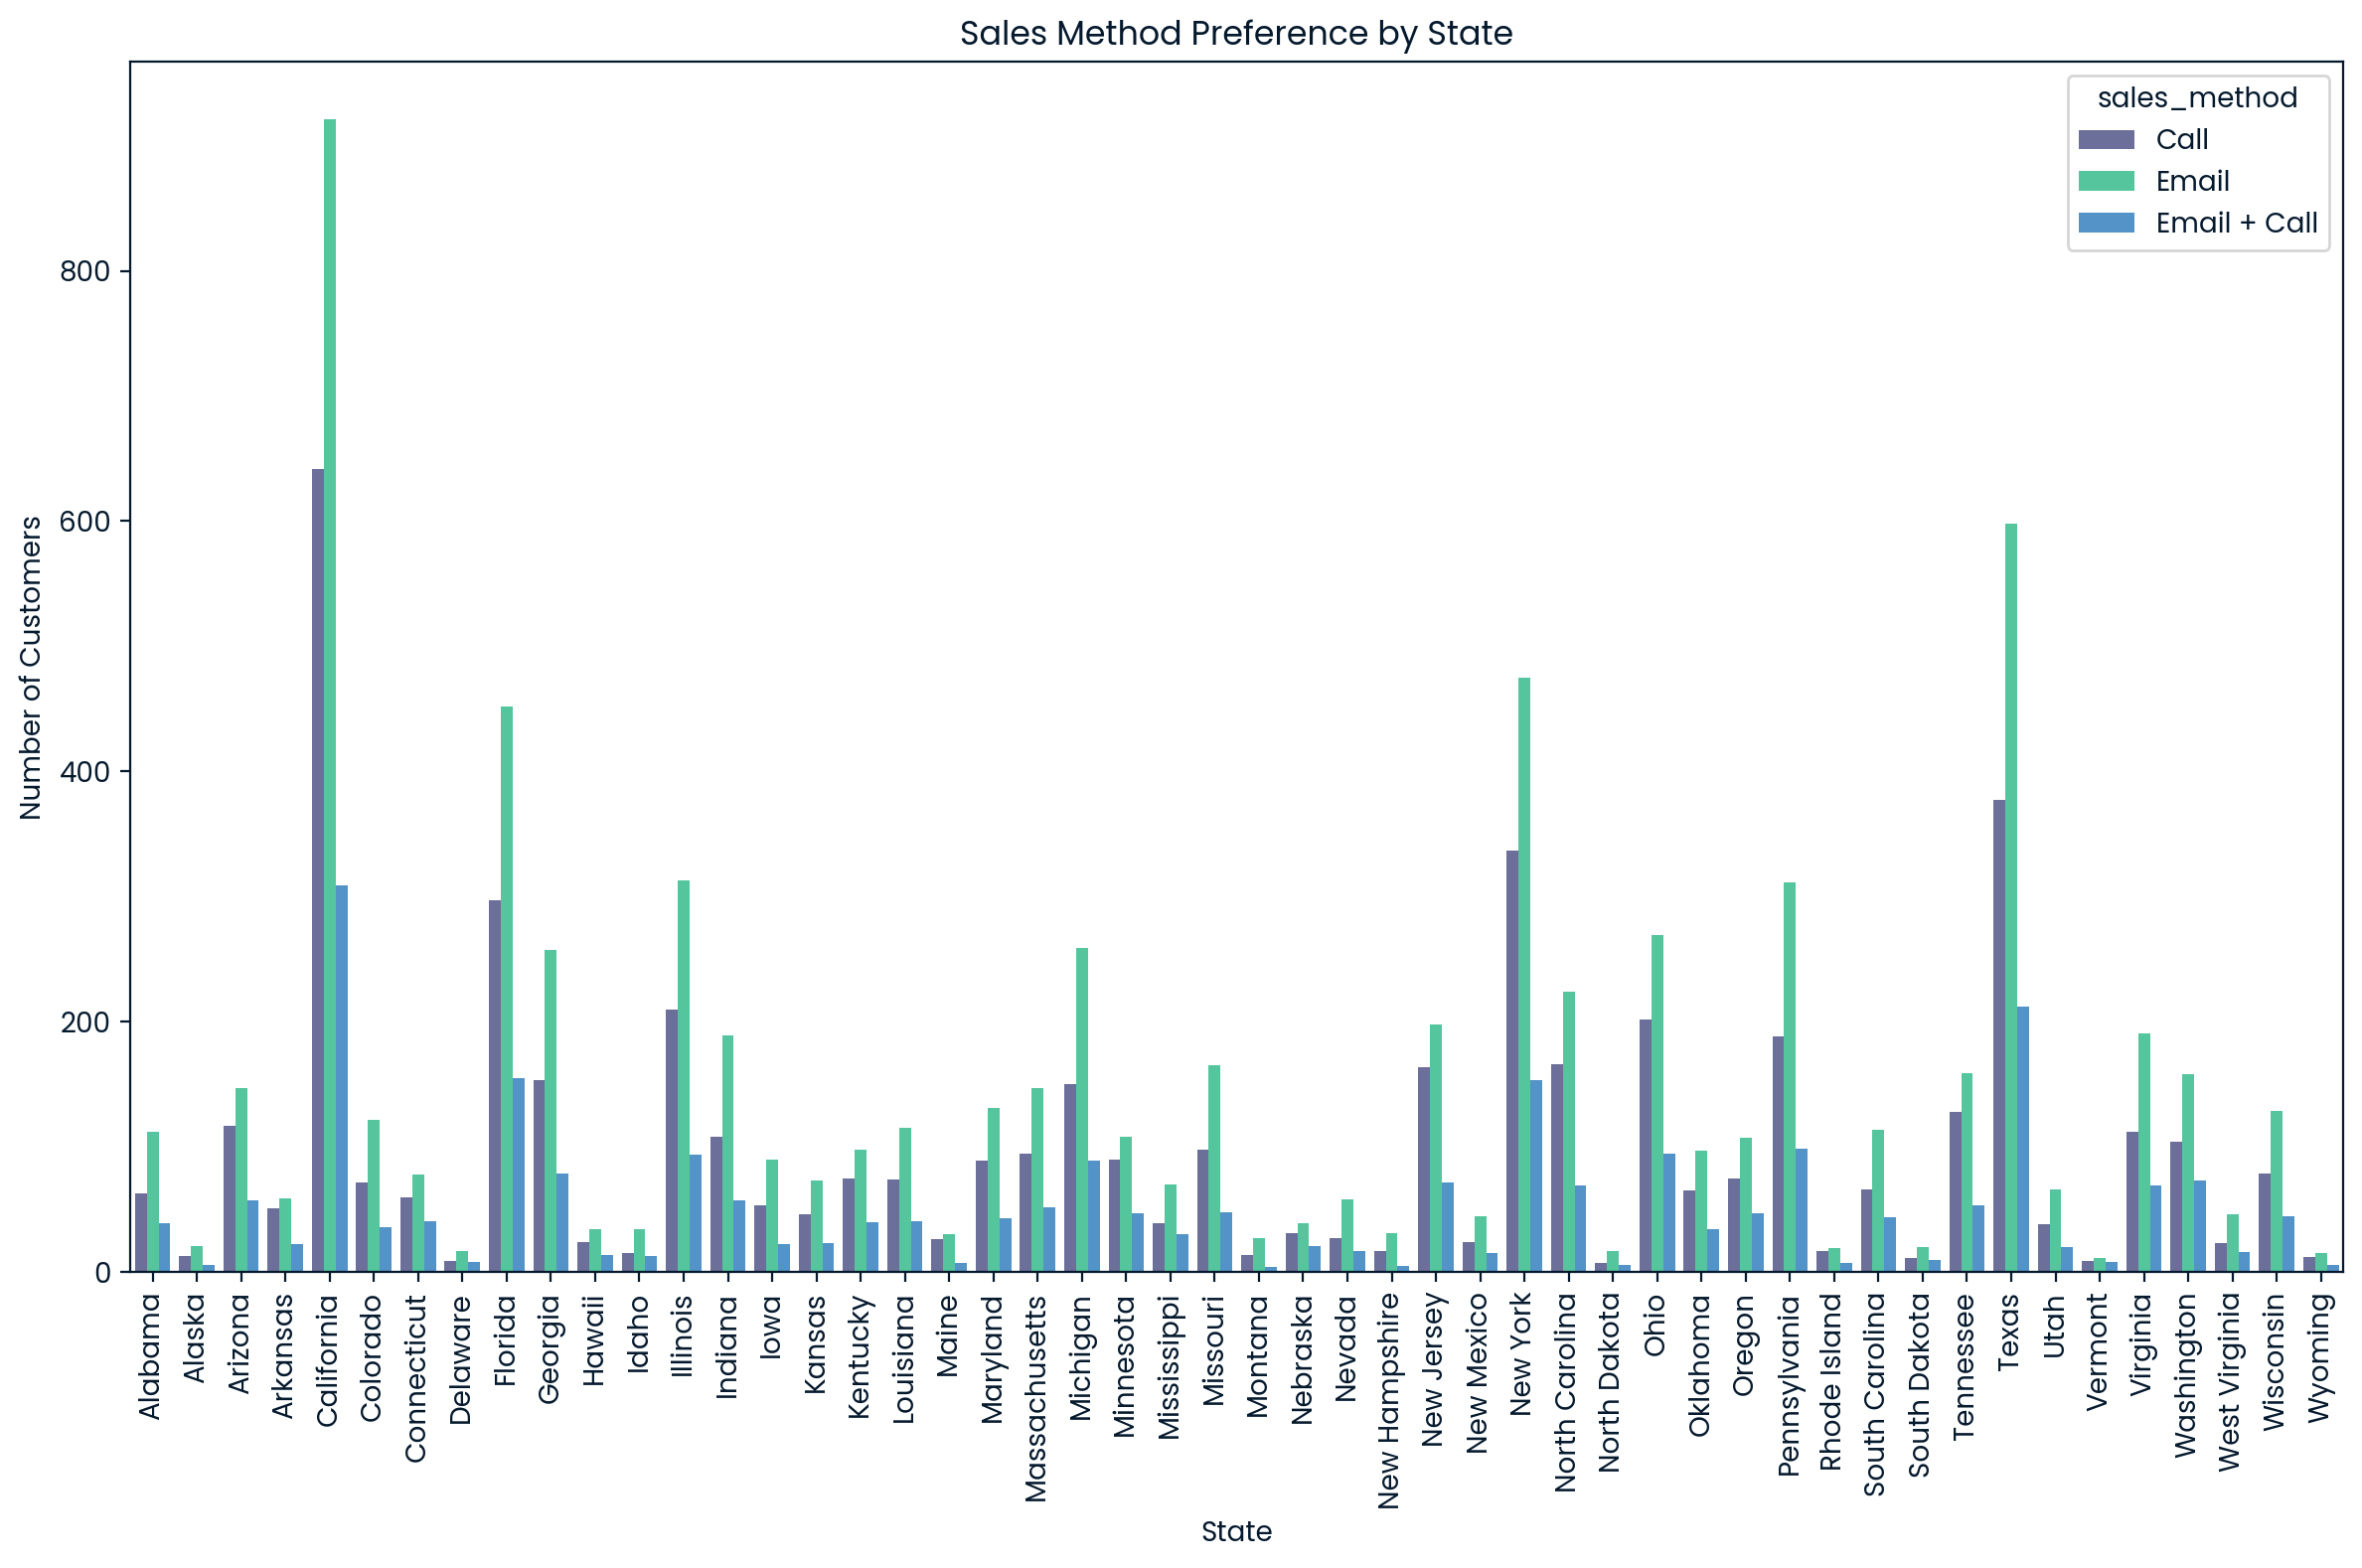

In [27]:
# Group by state and sales method to get the count of each method per region
state_method_counts = sales.groupby(['state', 'sales_method']).size().reset_index(name='counts')

# Create a grouped bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='state', y='counts', hue='sales_method', data=state_method_counts)

# Customize the plot
plt.title('Sales Method Preference by State')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)  # Rotate state labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()

In [28]:
sales['time_spent'] = sales['sales_method'].map({
    'Email': 5,  # assuming 5 minutes per email
    'Call': 30,  # assuming 30 minutes per call
    'Email + Call': 15  # assuming 5 minutes for email and 10 minutes for call
})

# Calculate revenue_per_item for each transaction
sales['revenue_per_item'] = sales['revenue'] / sales['nb_sold']

# Calculate revenue_per_time for each transaction
sales['revenue_per_time'] = sales['revenue'] / sales['time_spent']

# Apply the weights for the composite score for each transaction
weights = {
    'revenue_per_item': 0.3,
    'revenue_per_time': 0.4,
    'nb_site_visits': 0.1,
    'years_as_customer': 0.2,
}

# Calculate the composite score for each transaction
sales['composite_score'] = (sales['revenue_per_item'] * weights['revenue_per_item'] +
                            sales['revenue_per_time'] * weights['revenue_per_time'] +
                            sales['nb_site_visits'] * weights['nb_site_visits'] +
                            sales['years_as_customer'] * weights['years_as_customer'])

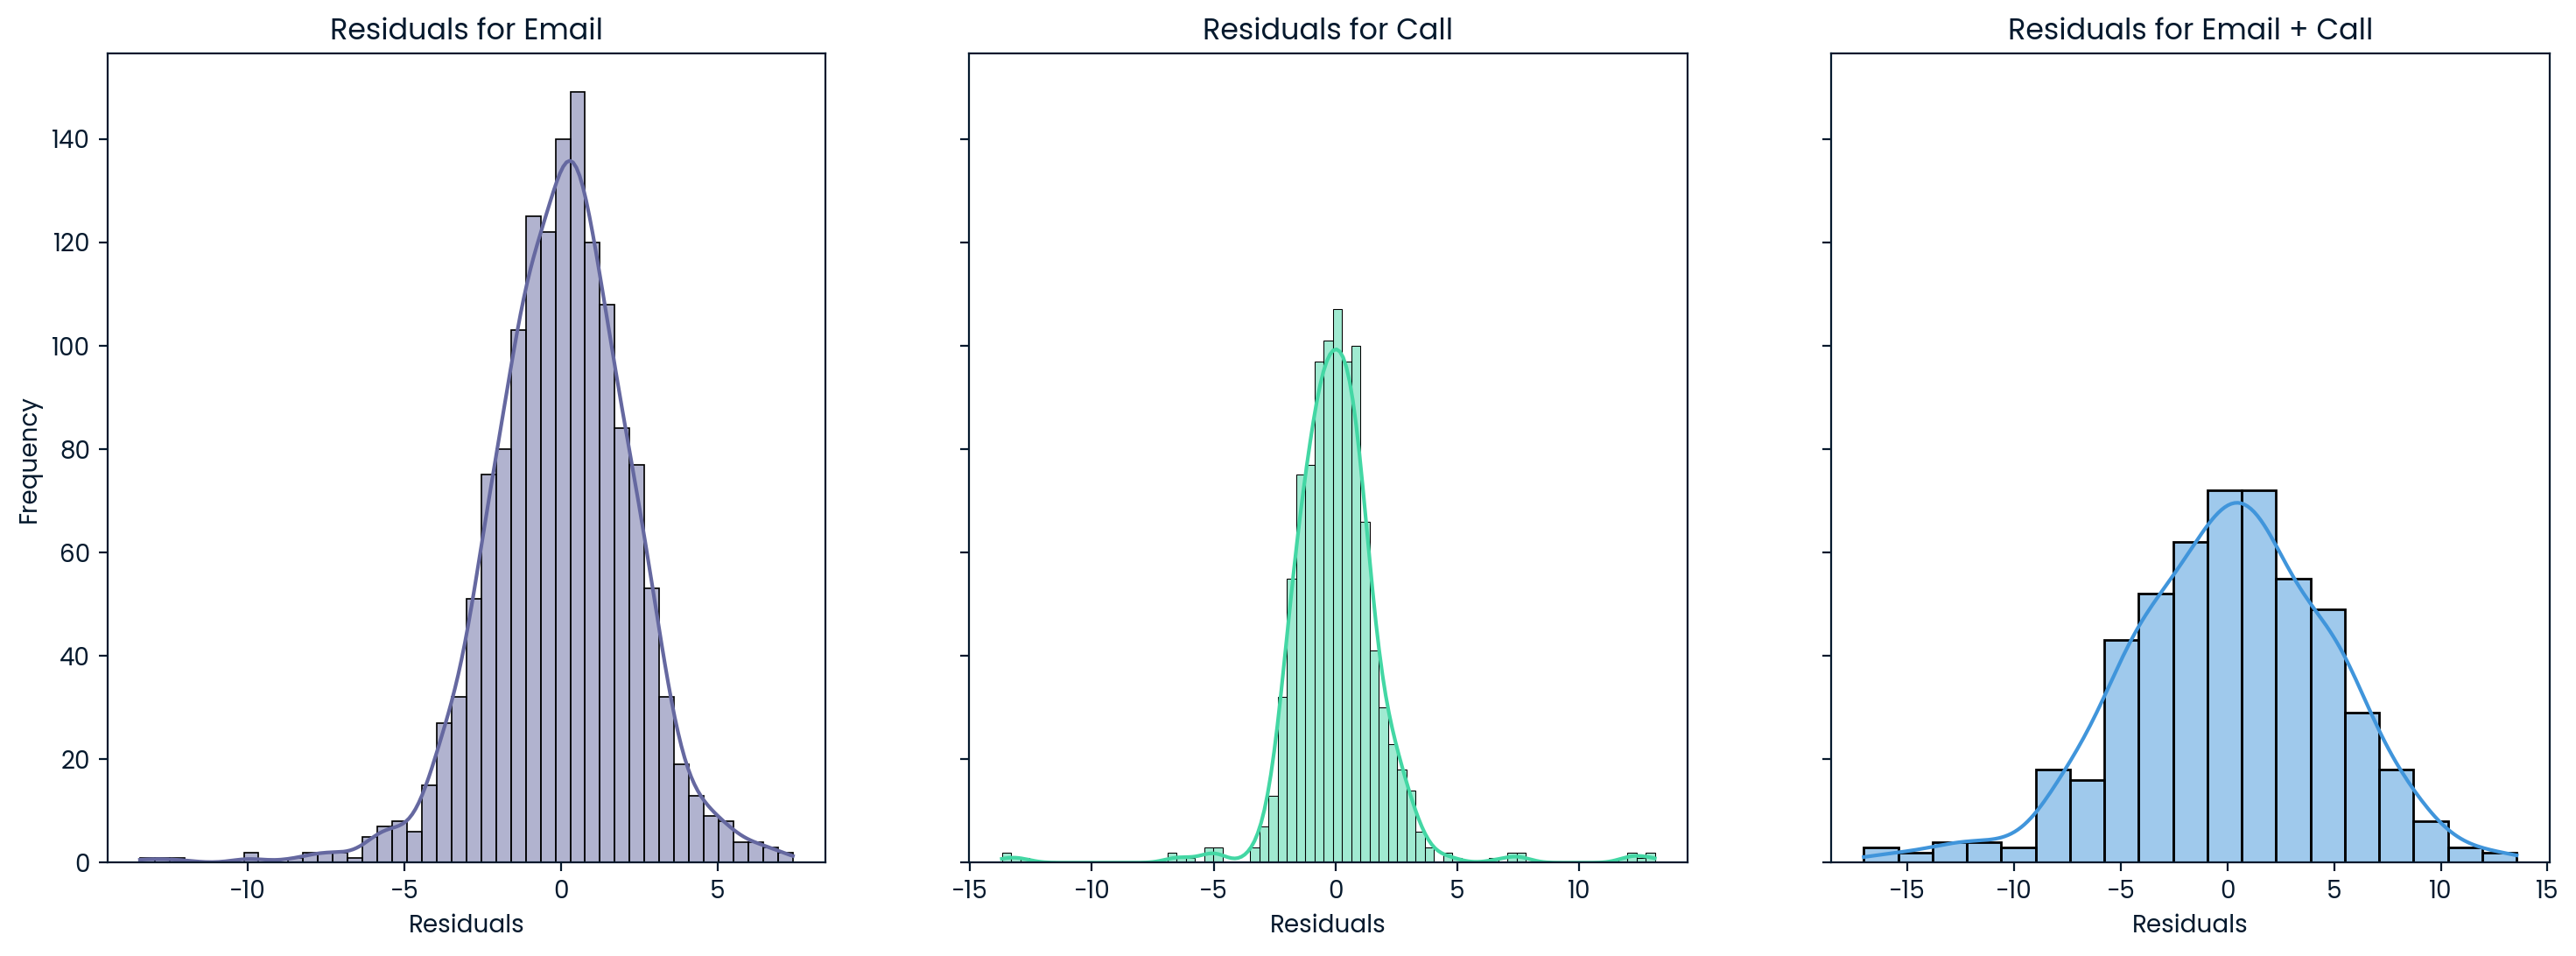

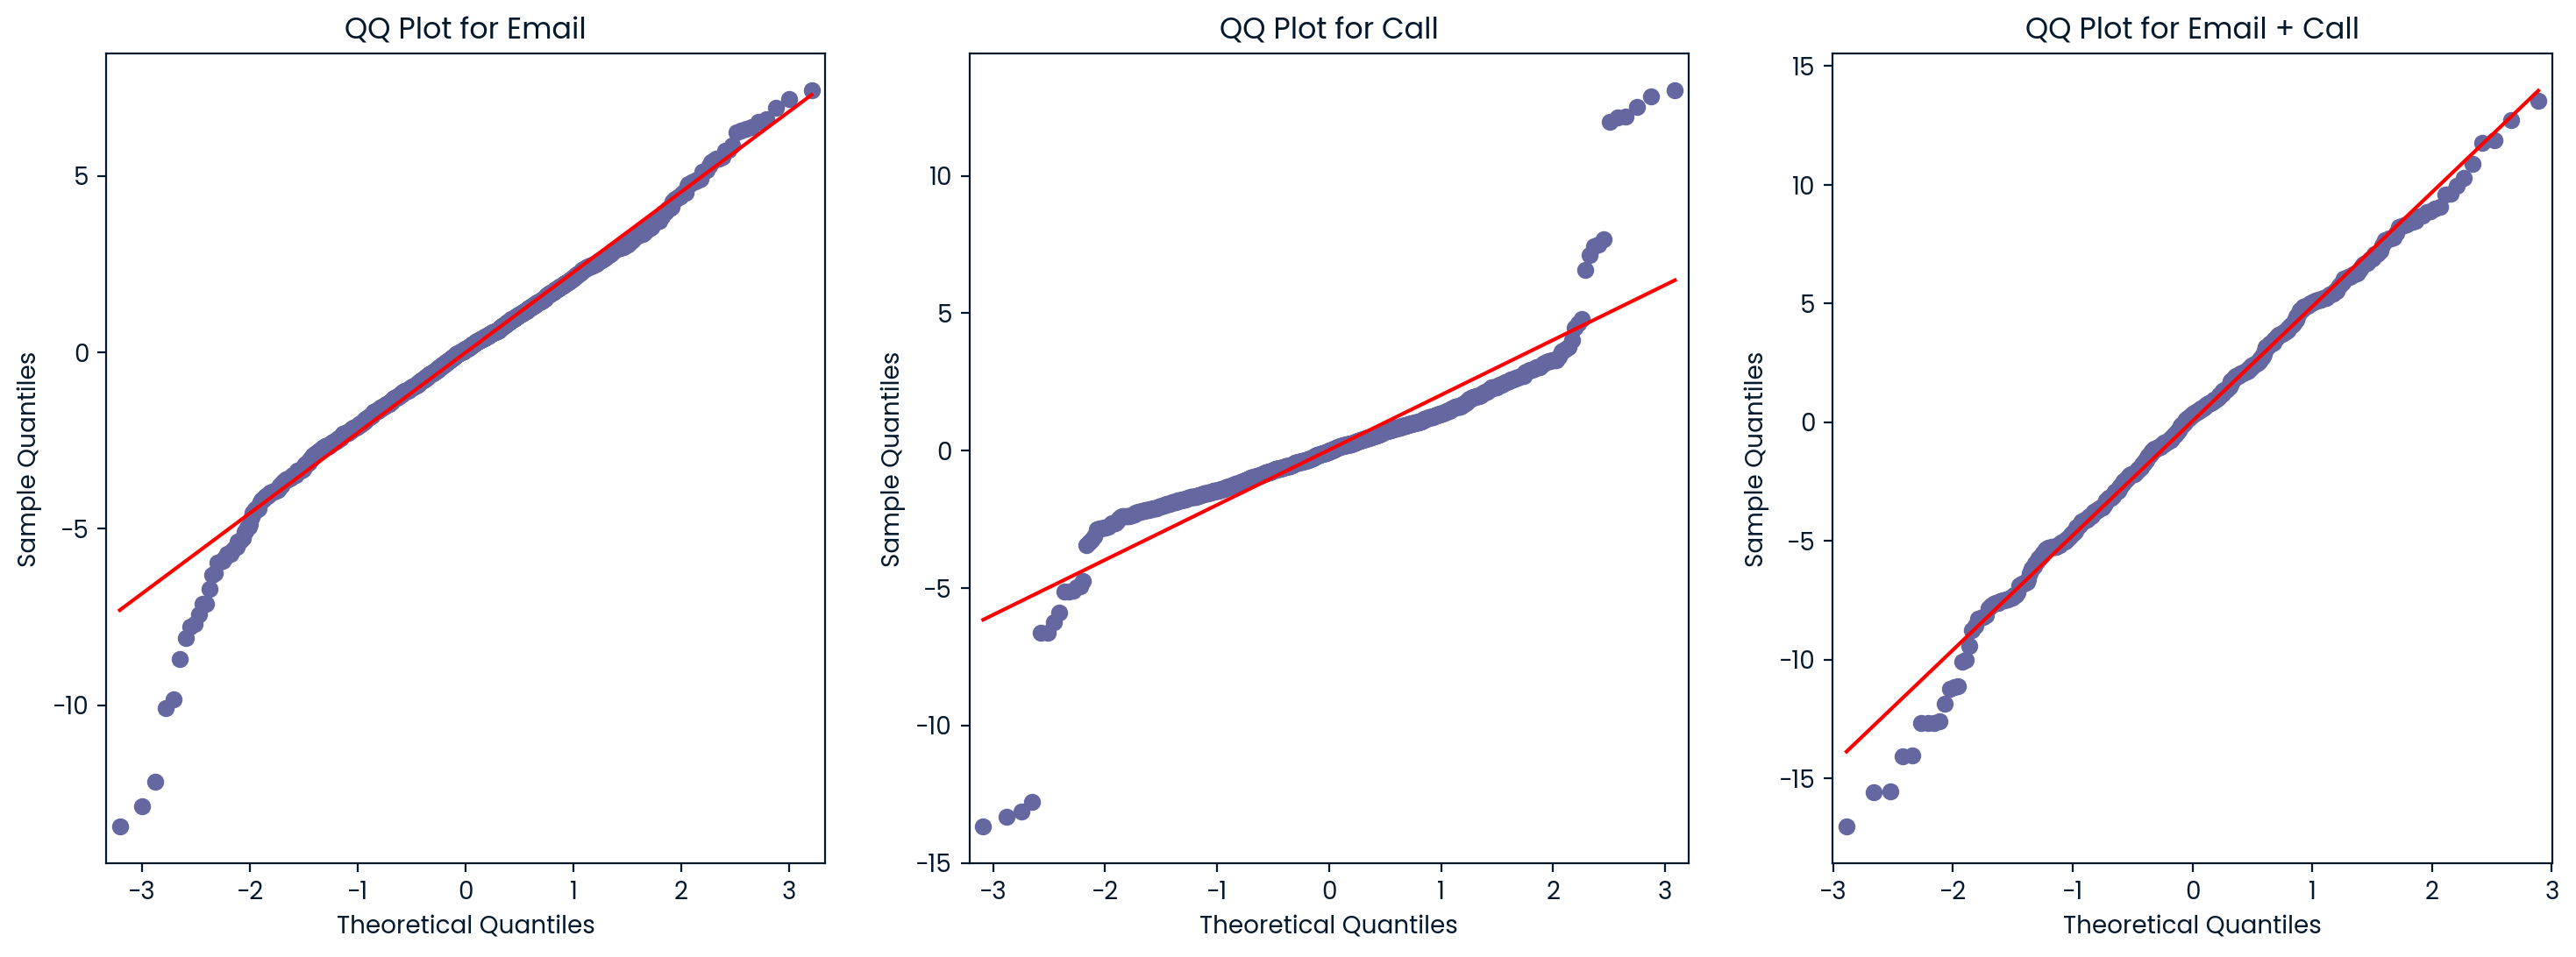

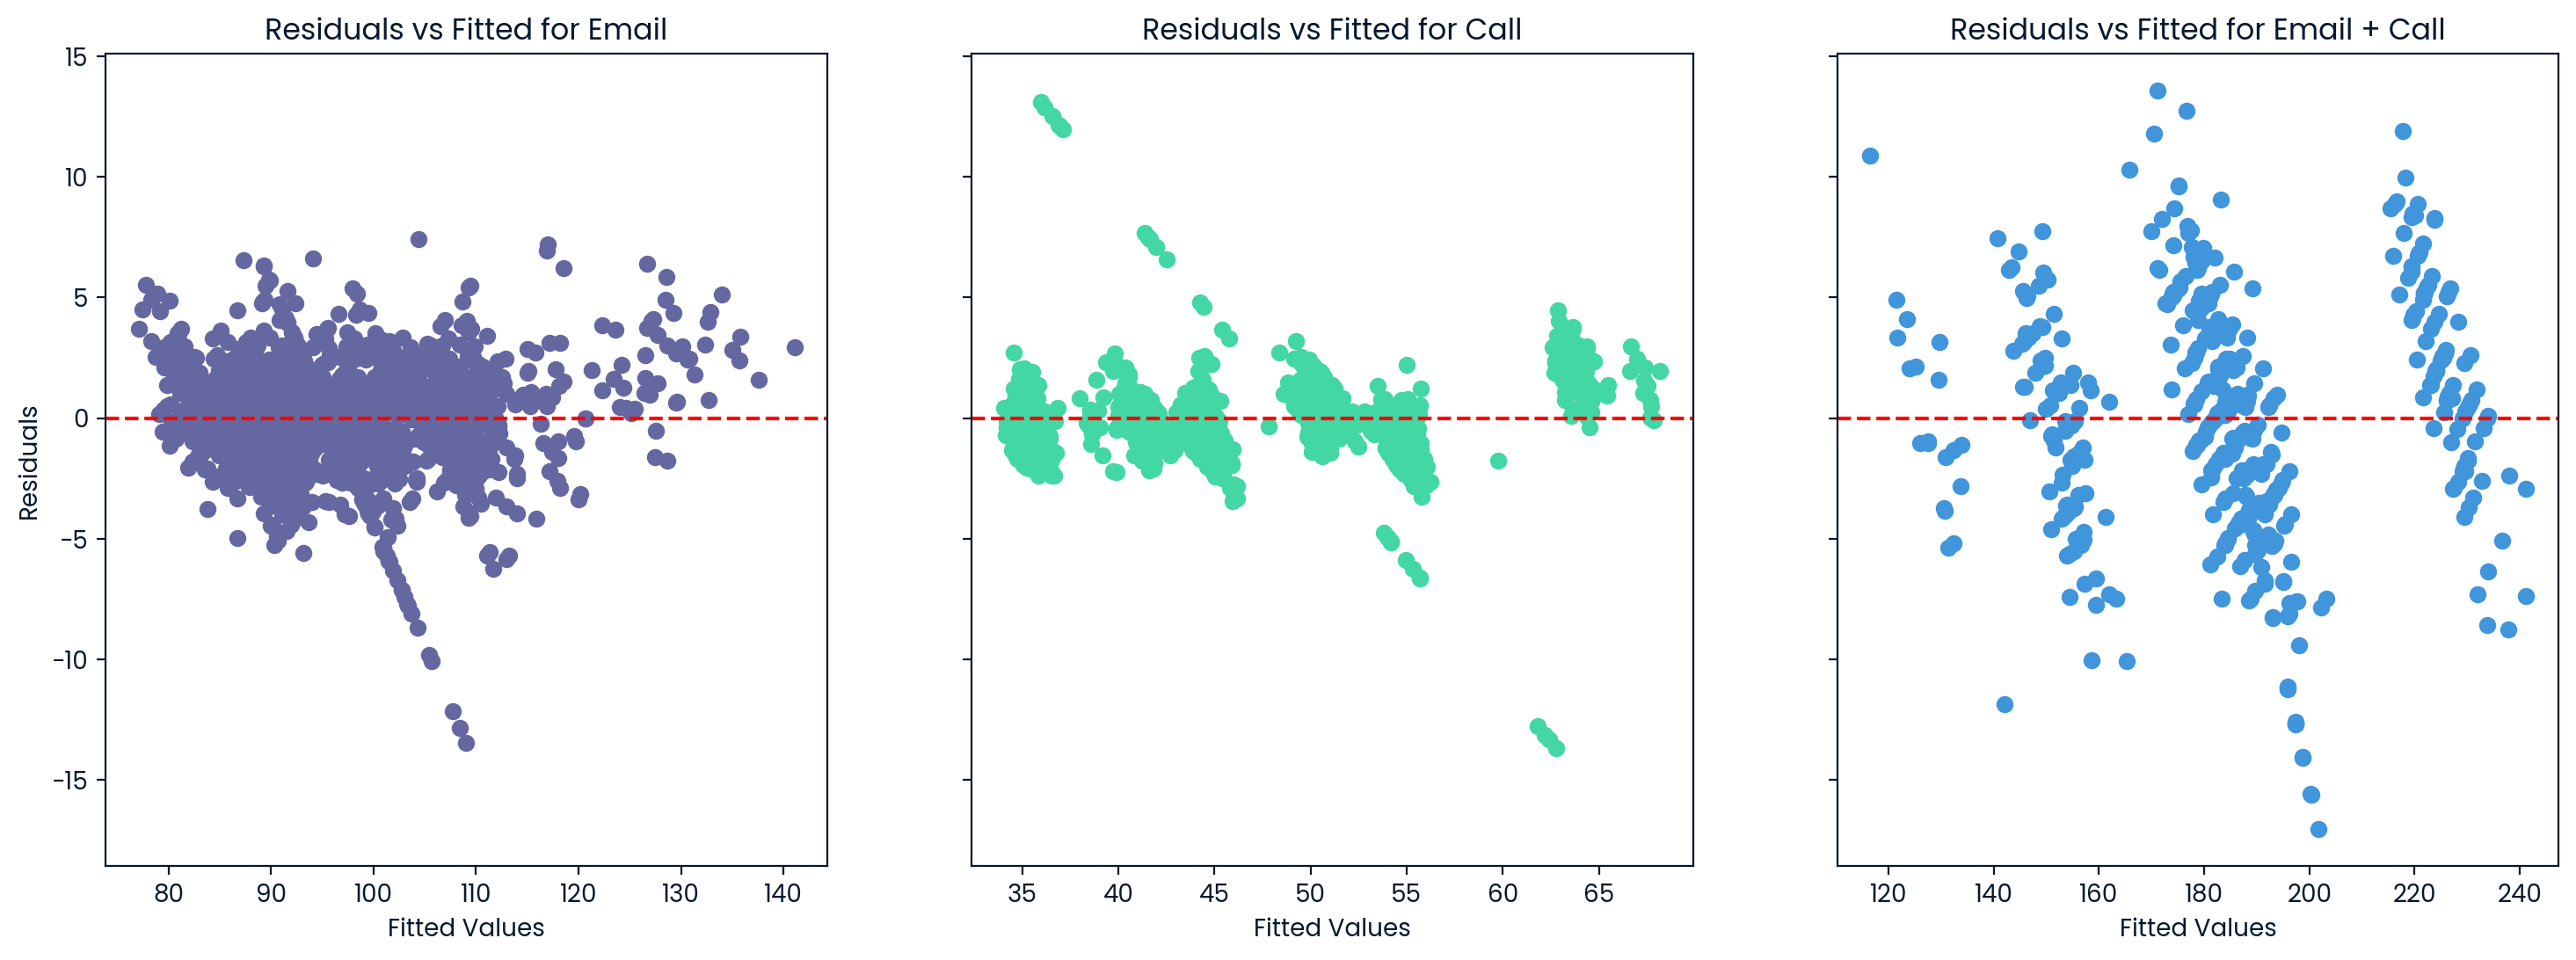

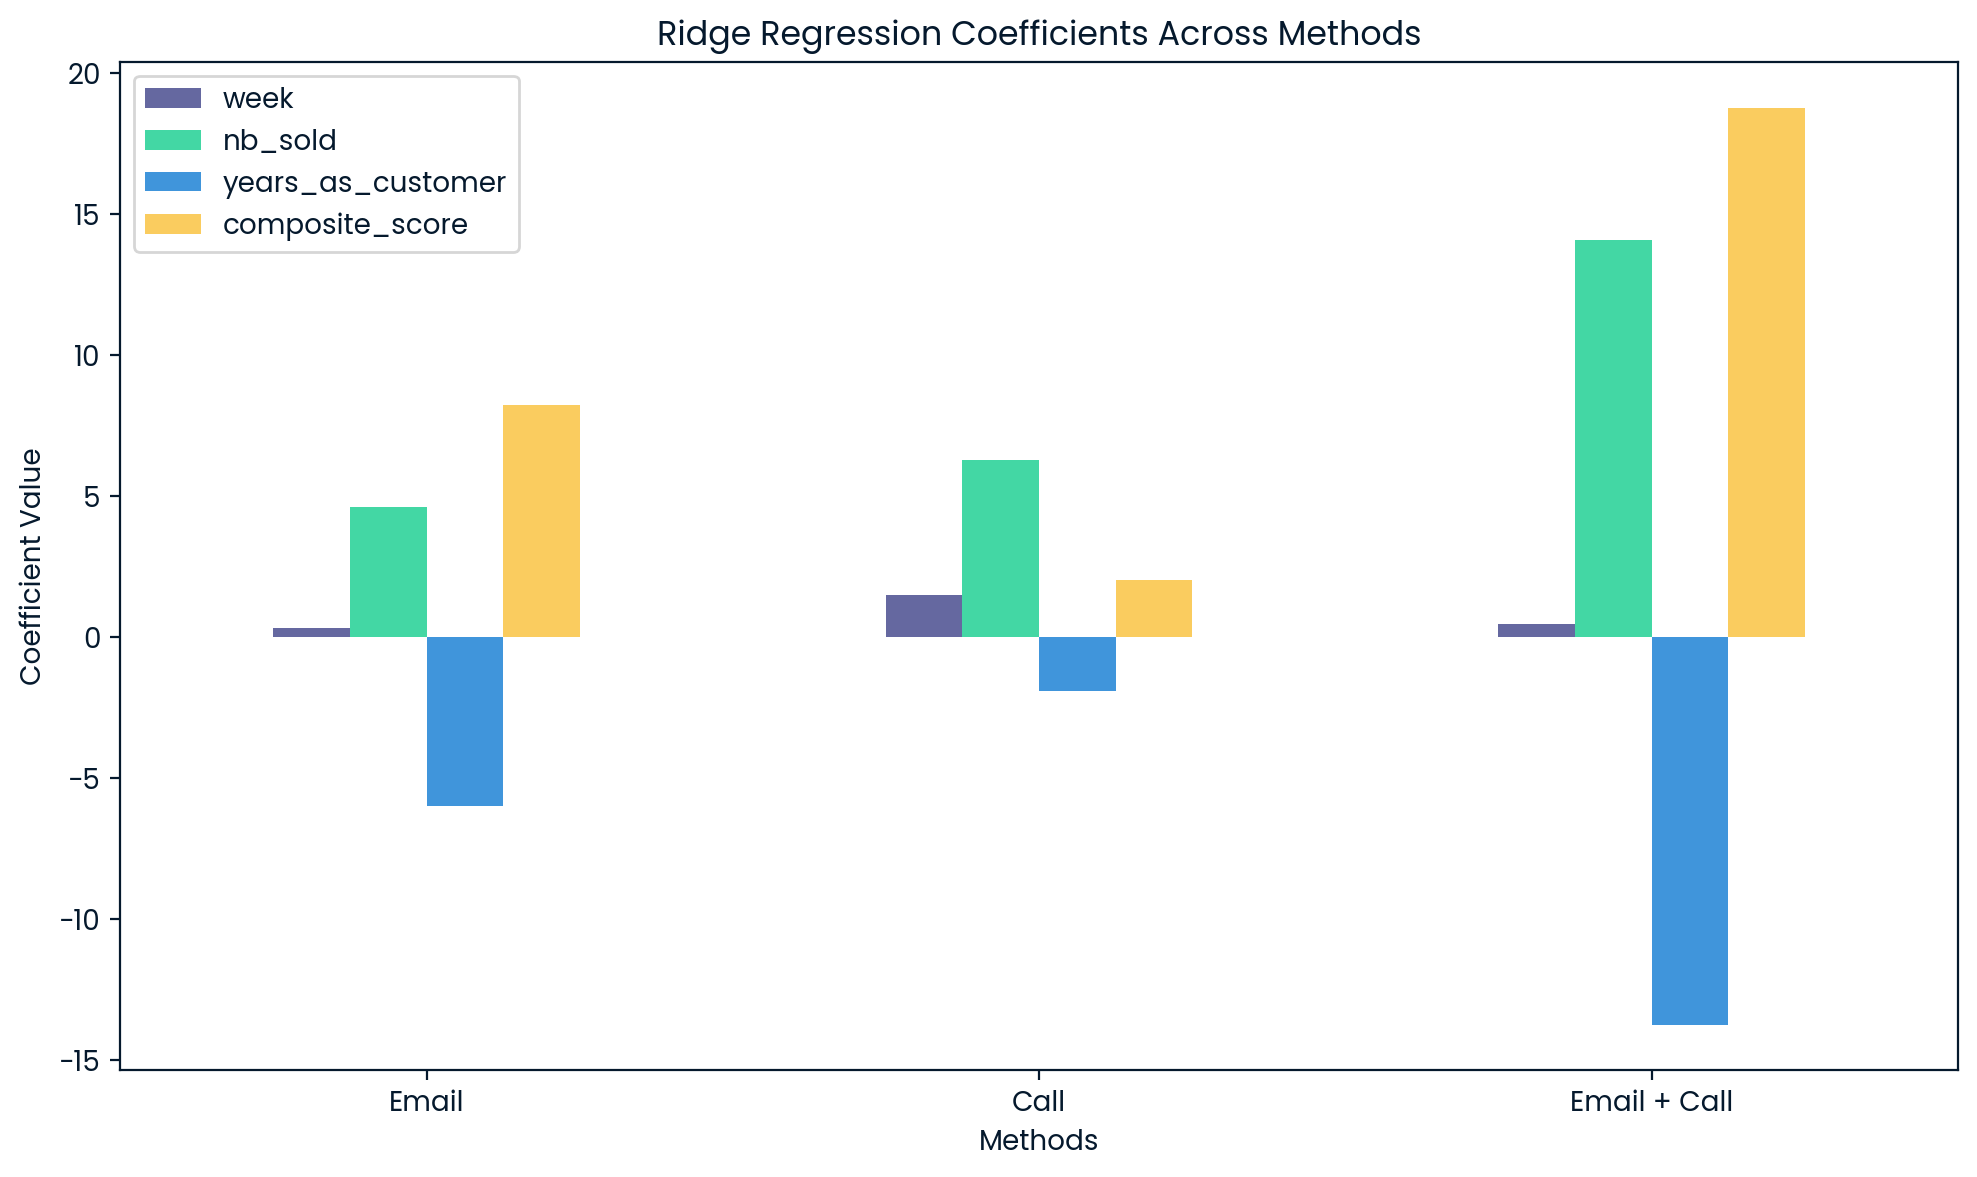

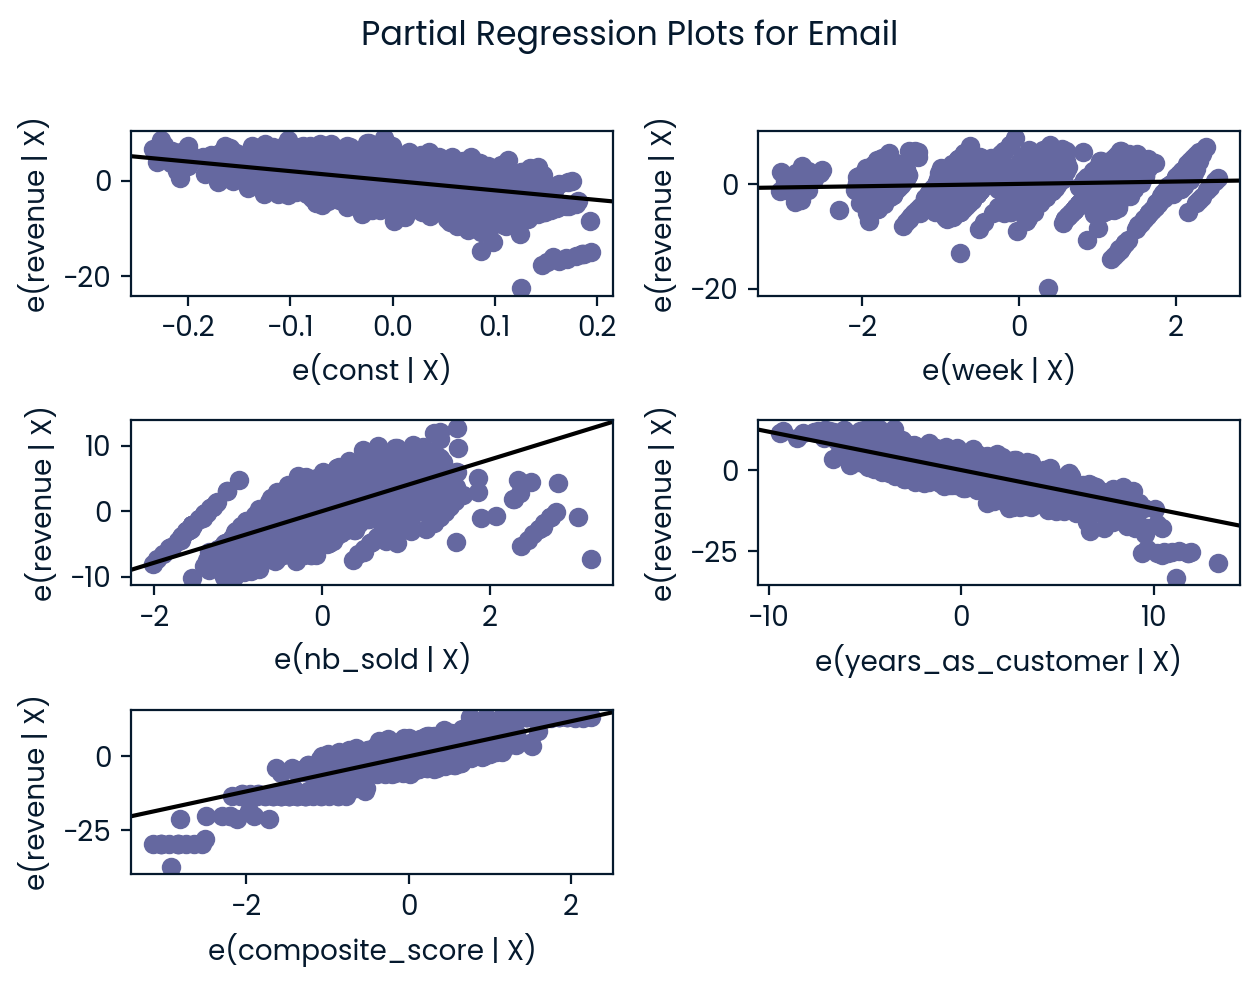

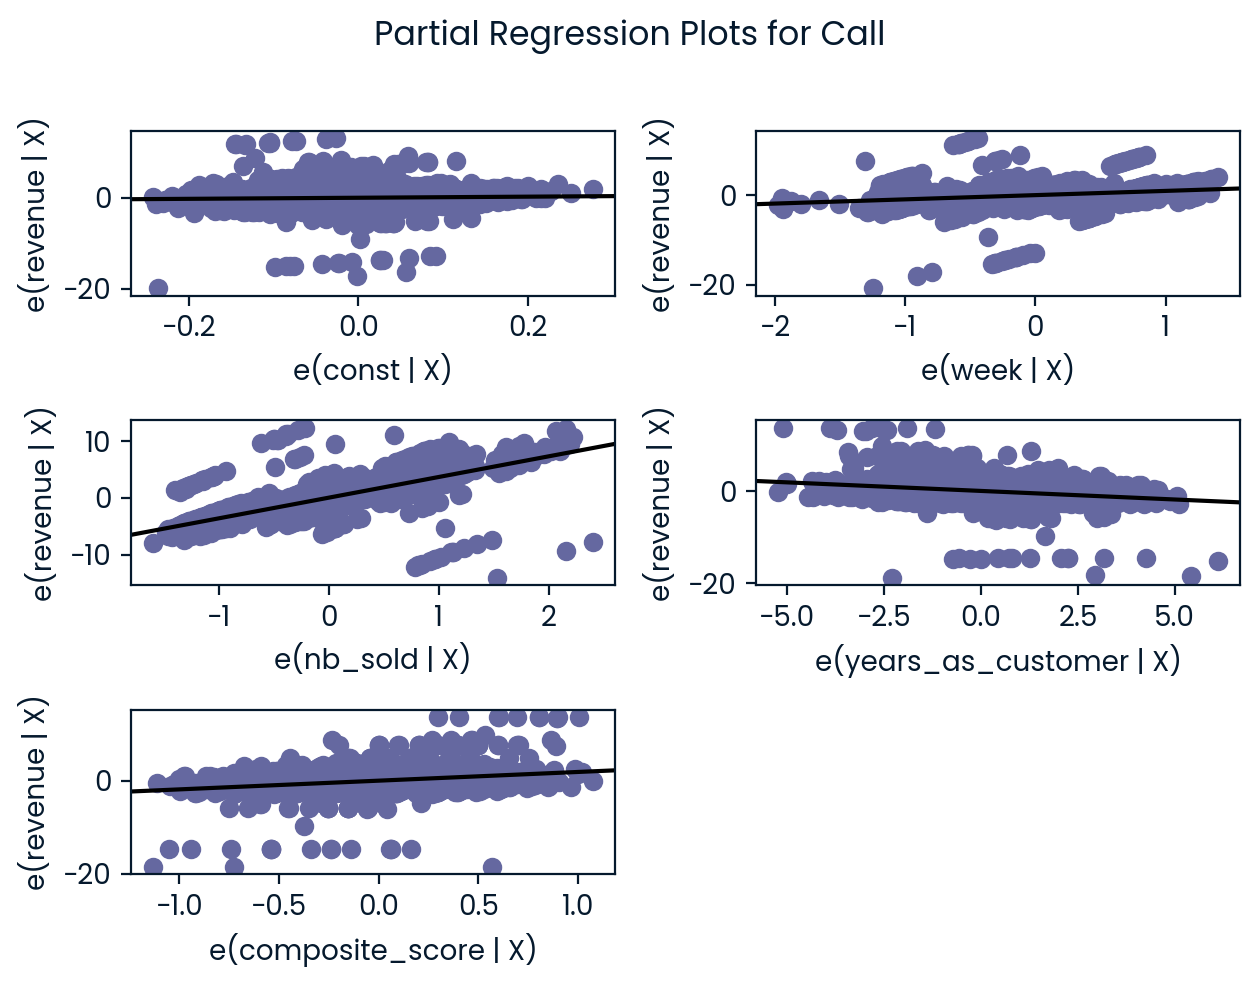

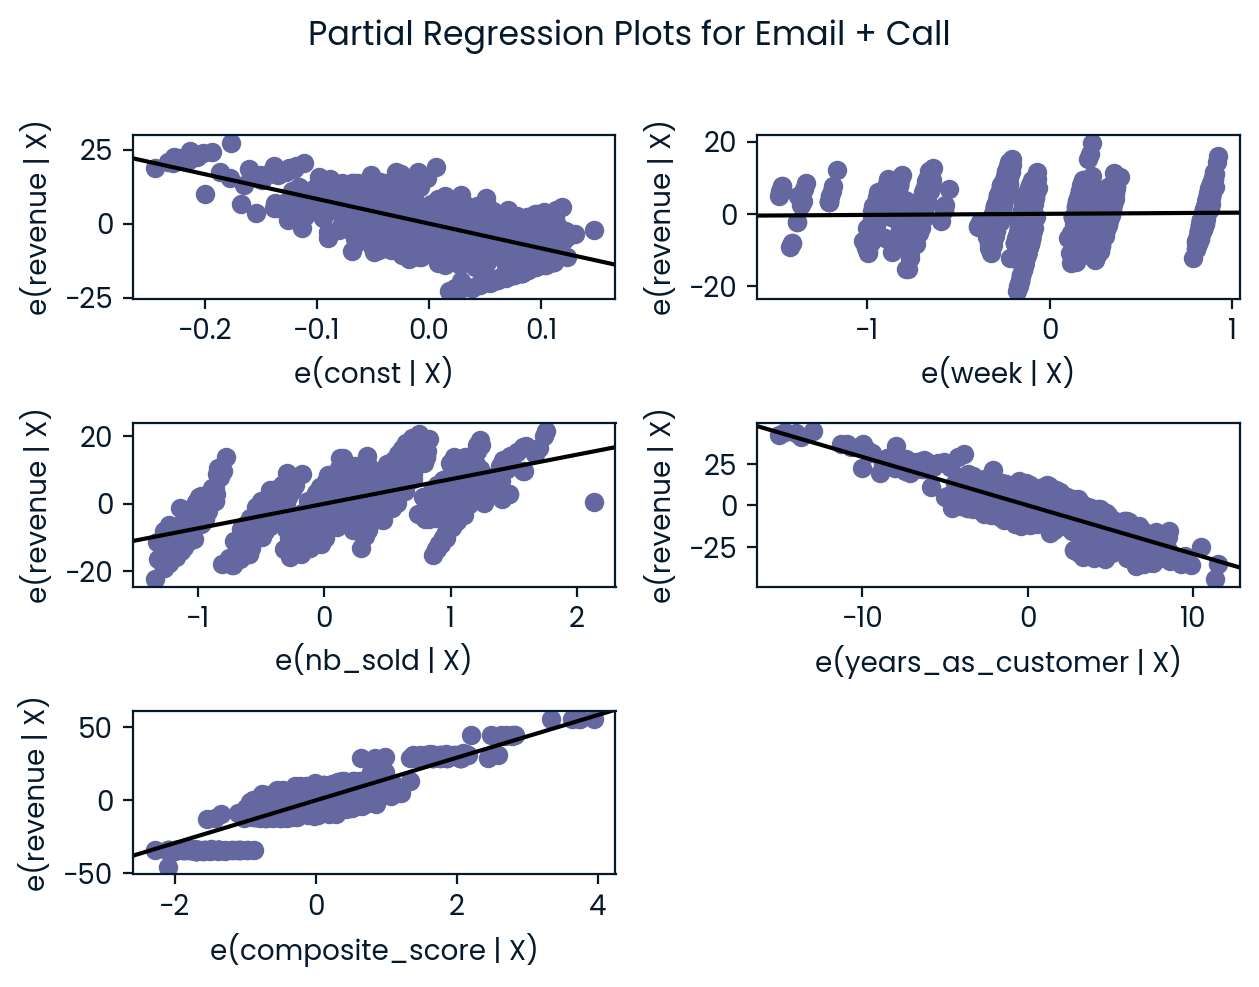

,Ridge Test MSE,Ridge Test R-squared,VIF
Method,,,
Email,5.179915,0.957087,"{'feature': {0: 'const', 1: 'week', 2: 'nb_sol..."
Call,4.001327,0.946199,"{'feature': {0: 'const', 1: 'week', 2: 'nb_sol..."
Email + Call,23.239999,0.965962,"{'feature': {0: 'const', 1: 'week', 2: 'nb_sol..."


In [35]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the features and target for each method
methods = ['Email', 'Call', 'Email + Call']
ridge_results = {}
residuals_all_methods = {}
coefficients_all_methods = {}
vif_all_methods = {}

# Define subplots for combined visualizations
fig_residuals, axs_residuals = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig_qq, axs_qq = plt.subplots(1, 3, figsize=(18, 6))
fig_fitted, axs_fitted = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig_coefficients, ax_coeff = plt.subplots(figsize=(10, 6))

for i, method in enumerate(methods):
    # Filter data for the given method
    method_data = sales[sales['sales_method'] == method]
    
    # Features and target
    X_method = method_data[['week', 'nb_sold', 'years_as_customer', 'composite_score']]
    y_method = method_data['revenue']
    
    # Split the data into training and test sets
    X_train_method, X_test_method, y_train_method, y_test_method = train_test_split(X_method, y_method, test_size=0.2, random_state=42)
    
    # Standardize the data
    scaler = StandardScaler()
    X_train_method_scaled = scaler.fit_transform(X_train_method)
    X_test_method_scaled = scaler.transform(X_test_method)
    
    # Ridge regression with cross-validation
    ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
    ridge.fit(X_train_method_scaled, y_train_method)
    
    # Predict and evaluate Ridge model
    y_pred_ridge = ridge.predict(X_test_method_scaled)
    
    # Store the results
    ridge_results[method] = {
        'coefficients': ridge.coef_,
        'MSE': mean_squared_error(y_test_method, y_pred_ridge),
        'R-squared': r2_score(y_test_method, y_pred_ridge)
    }
    
    # Store coefficients for comparison
    coefficients_all_methods[method] = ridge.coef_
    
    # Residuals
    residuals = y_test_method - y_pred_ridge
    residuals_all_methods[method] = residuals
    
    # Combined Histogram of Residuals
    sns.histplot(residuals, kde=True, ax=axs_residuals[i], color=sns.color_palette()[i])
    axs_residuals[i].set_title(f'Residuals for {method}')
    axs_residuals[i].set_xlabel('Residuals')
    axs_residuals[i].set_ylabel('Frequency' if i == 0 else '')

    # Combined QQ plot
    sm.qqplot(residuals, line='s', ax=axs_qq[i])
    axs_qq[i].set_title(f'QQ Plot for {method}')
    
    # Combined Residuals vs Fitted
    axs_fitted[i].scatter(y_pred_ridge, residuals, color=sns.color_palette()[i])
    axs_fitted[i].axhline(0, color='red', linestyle='--')
    axs_fitted[i].set_title(f'Residuals vs Fitted for {method}')
    axs_fitted[i].set_xlabel('Fitted Values')
    axs_fitted[i].set_ylabel('Residuals' if i == 0 else '')
    
    # VIF Calculation
    X_train_sm = sm.add_constant(X_train_method)  # Add constant for intercept
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_train_sm.columns
    vif_data['VIF'] = [variance_inflation_factor(X_train_sm, j) for j in range(X_train_sm.shape[1])]
    vif_all_methods[method] = vif_data
    
# Plot combined coefficients in a single bar chart
coefficients_df = pd.DataFrame(coefficients_all_methods, index=X_method.columns).T
coefficients_df.plot(kind='bar', ax=ax_coeff)
ax_coeff.set_title('Ridge Regression Coefficients Across Methods')
ax_coeff.set_xlabel('Methods')
ax_coeff.set_ylabel('Coefficient Value')
plt.xticks(rotation=0)

# Show combined plots
plt.tight_layout()
plt.show()

# Display combined residual plots
fig_residuals.tight_layout()
fig_qq.tight_layout()
fig_fitted.tight_layout()
plt.show()

# Partial regression plots with LinearRegression as a proxy
for method in methods:
    method_data = sales[sales['sales_method'] == method]
    
    X_method = method_data[['week', 'nb_sold', 'years_as_customer', 'composite_score']]
    y_method = method_data['revenue']
    
    X_train, X_test, y_train, y_test = train_test_split(X_method, y_method, test_size=0.2, random_state=42)
    
    # Linear regression using statsmodels to create partial regression plots
    X_train_sm = sm.add_constant(X_train)  # Add constant for intercept
    ols_model = sm.OLS(y_train, X_train_sm).fit()  # Fit OLS on training data
    
    # Partial regression plots
    sm.graphics.plot_partregress_grid(ols_model)
    plt.suptitle(f'Partial Regression Plots for {method}', y=1.02)
    plt.tight_layout()
    plt.show()

# Output Results in a Report-Ready Table Format
ridge_report = []

for method in methods:
    ridge_report.append({
        'Method': method,
        'Ridge Coefficients': ridge_results[method]['coefficients'],
        'Ridge Test MSE': ridge_results[method]['MSE'],
        'Ridge Test R-squared': ridge_results[method]['R-squared'],
        'VIF': vif_all_methods[method].to_dict()
    })

# Display report summary in a tabular format
import pandas as pd
ridge_summary_df = pd.DataFrame(ridge_report)
ridge_summary_df[['Method', 'Ridge Test MSE', 'Ridge Test R-squared', 'VIF']].set_index('Method')



